# 🚀 Customize and Deploy `Qwen/Qwen3-VL-4B-Instruct` on Amazon SageMaker AI

---

In this notebook, we explore **Qwen3-VL-4B-Instruct**, a ~4-billion-parameter vision-language instruction-tuned model from Alibaba’s Qwen3 “VL” series. You’ll learn how to fine-tune it with image + text instruction workflows, evaluate its vision-language output performance, and deploy it via SageMaker for multimodal assistant use cases.

**What is Qwen3-VL-4B-Instruct?**
Qwen3-VL-4B-Instruct is a vision-language (“VL”) variant of the Qwen3 model family, tuned for instruction-following tasks that involve image (and text) inputs and text outputs. The “4B” denotes the parameter scale (~4 billion), and “Instruct” signals it is optimized for human-instruction compatibility. The broader Qwen3 model family is open-weight and released under the **Apache-2.0** license.

---

**Key Specifications**

| Feature                   | Details                                                                          |
| ------------------------- | -------------------------------------------------------------------------------- |
| **Parameters**            | ~4 billion                                                                       |
| **Modalities**            | Image + Text input → Text output                                                 |
| **Context / Window Size** | Large text context (e.g., 32 K+ tokens) combined with vision inputs              |
| **Architecture**          | Dense Transformer backbone + vision encoder front end + instruction-tuned output |
| **License**               | Apache-2.0                                                                       |

---

**Benchmarks & Behavior**

* The Qwen3 series reports strong performance across vision-language reasoning, multilingual understanding, and instruction-following.
* At the ~4B scale, this model offers a strong balance of **capability vs efficiency**, delivering vision-language assistant functionality at moderate hardware cost.
* Ideal for tasks where image comprehension + instruction-based response is required, such as visual question answering, image-guided advice, captioning with user queries.

---

**Using This Notebook**

Here’s what you’ll cover:

* Load a sample image + instruction dataset from Hugging Face and prepare it for fine-tuning
* Fine-tune with SageMaker Training Jobs
* Run model evaluation (vision + instruction tasks)
* Deploy to SageMaker Endpoints


In [1]:
# %pip install -Uq sagemaker datasets

In [2]:
import boto3
import sagemaker

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ubuntu/.config/sagemaker/config.yaml


In [3]:
region = boto3.Session().region_name

from sagemaker.local import LocalSession 
sess = LocalSession() #sagemaker.Session(boto3.Session(region_name=region))
sess.config = {"local": {"local_code": True}}

sagemaker_session_bucket = None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()

In [4]:
print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::811828458885:role/Admin
sagemaker bucket: sagemaker-us-east-1-811828458885
sagemaker session region: us-east-1


## Data Preparation for Supervised Fine-tuning

### [DoclingMatix](https://huggingface.co/datasets/HuggingFaceM4/DoclingMatix)

**DoclingMatix** is a large-scale, multimodal dataset designed for document-intelligence tasks involving vision + instruction-tuned structured output. Built by augmenting the original Docmatix dataset, DoclingMatix converts each document image and QA pair into an instruction-based format for document conversion or visual question answering.

**Data Format & Structure**:

* Distributed in **Parquet** and/or **JSONL** formats.
* Contains a single `train` split with approximately **1,270,911** samples.
* Each record includes:

  * `images` – one or more images of the document page(s)
  * `instruction` – a natural-language prompt specifying the desired conversion or QA task (e.g., “Convert this page into structured DocTag format” or “Answer the question about the document”)
  * `response` – the target output (structured text or answer)

**License**: Released under the terms indicated on the Hugging Face dataset page (please verify before use).

**Applications**:

The dataset can support a variety of document-intelligence tasks, including:

* Instruction-tuned document conversion (image + instruction → structured text)
* Document visual question answering (DocVQA) and document understanding workflows
* Training vision–language models that parse document layouts and generate structured outputs
* Fine-tuning multimodal assistants or agents for enterprises, knowledge work, and document automation


In [5]:
import os
import io
import base64
import json
import pprint
from tqdm import tqdm
from datasets import load_dataset

In [6]:
dataset_parent_path = os.path.join(os.getcwd(), "tmp_cache_local_dataset")
os.makedirs(dataset_parent_path, exist_ok=True)

**Preparing Your Dataset in `messages` format**

This section walks you through creating a conversation-style dataset—the required `messages` format—for directly training LLMs using SageMaker AI.

**What Is the `messages` Format?**

The `messages` format structures instances as chat-like exchanges, wrapping each conversation turn into a role-labeled JSON array. It’s widely used by frameworks like TRL.

Example entry:

```json
{
  "messages": [
    { "role": "system", "content": "You are a helpful assistant." },
    { "role": "user", "content": "How do I bake sourdough?" },
    { "role": "assistant", "content": "First, you need to create a starter by..." }
  ]
}


In [7]:
os.environ["HF_HOME_CACHE"]="/opt/dlami/nvme/pranavvm-tmp/"

In [8]:
dataset_name = "HuggingFaceM4/DoclingMatix"
dataset = load_dataset(dataset_name, split="train[:100]")

Resolving data files:   0%|          | 0/1104 [00:00<?, ?it/s]

train-00000-of-01106-8ce5201aa40b0141.pa(…):   0%|          | 0.00/798M [00:00<?, ?B/s]

train-00001-of-01106-97f9db5e7314e467.pa(…):   0%|          | 0.00/782M [00:00<?, ?B/s]

train-00002-of-01106-2df0467087cd12cb.pa(…):   0%|          | 0.00/801M [00:00<?, ?B/s]

train-00003-of-01106-2bdb0522e322f17c.pa(…):   0%|          | 0.00/836M [00:00<?, ?B/s]

train-00004-of-01106-0c340d9a64fe9b09.pa(…):   0%|          | 0.00/823M [00:00<?, ?B/s]

train-00005-of-01106-eb9495f3368dc674.pa(…):   0%|          | 0.00/813M [00:00<?, ?B/s]

train-00006-of-01106-886d145d25483785.pa(…):   0%|          | 0.00/853M [00:00<?, ?B/s]

train-00007-of-01106-9d4daa5599858f25.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-00008-of-01106-63ced42496e0d2a8.pa(…):   0%|          | 0.00/808M [00:00<?, ?B/s]

train-00009-of-01106-c64833d4e011fb12.pa(…):   0%|          | 0.00/894M [00:00<?, ?B/s]

train-00010-of-01106-68ed55e7b9f347da.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00011-of-01106-a3c35de9d47aff6d.pa(…):   0%|          | 0.00/788M [00:00<?, ?B/s]

train-00012-of-01106-a8759b0b373a24f1.pa(…):   0%|          | 0.00/836M [00:00<?, ?B/s]

train-00013-of-01106-ebdff7af1faa1df3.pa(…):   0%|          | 0.00/853M [00:00<?, ?B/s]

train-00014-of-01106-90f7fbfc7f51e501.pa(…):   0%|          | 0.00/858M [00:00<?, ?B/s]

train-00015-of-01106-5a97ed2b3982e8e5.pa(…):   0%|          | 0.00/825M [00:00<?, ?B/s]

train-00016-of-01106-9c55fc3ed5dc3573.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00017-of-01106-bdaad1c2f761acff.pa(…):   0%|          | 0.00/825M [00:00<?, ?B/s]

train-00018-of-01106-f25eba66277aaf5d.pa(…):   0%|          | 0.00/792M [00:00<?, ?B/s]

train-00019-of-01106-42e0dd0f7f226497.pa(…):   0%|          | 0.00/788M [00:00<?, ?B/s]

train-00020-of-01106-dd9a1783af91e2b4.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00021-of-01106-c80c10e9eb721931.pa(…):   0%|          | 0.00/861M [00:00<?, ?B/s]

train-00022-of-01106-064ed960e7326e54.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00023-of-01106-c3142604dde6dedb.pa(…):   0%|          | 0.00/812M [00:00<?, ?B/s]

train-00024-of-01106-080056e62002a0bd.pa(…):   0%|          | 0.00/823M [00:00<?, ?B/s]

train-00025-of-01106-3053f2c24a6807cf.pa(…):   0%|          | 0.00/828M [00:00<?, ?B/s]

train-00026-of-01106-ea75af4489185b0f.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00027-of-01106-fadbeb9f26827d83.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00028-of-01106-1250a3b52cd1f11a.pa(…):   0%|          | 0.00/838M [00:00<?, ?B/s]

train-00029-of-01106-f35092773987ea4d.pa(…):   0%|          | 0.00/812M [00:00<?, ?B/s]

train-00030-of-01106-1156e62085aed94a.pa(…):   0%|          | 0.00/839M [00:00<?, ?B/s]

train-00031-of-01106-6d6c4965e6b09e2d.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00032-of-01106-5be4e3a214462930.pa(…):   0%|          | 0.00/813M [00:00<?, ?B/s]

train-00033-of-01106-9ea599fc39dee629.pa(…):   0%|          | 0.00/810M [00:00<?, ?B/s]

train-00034-of-01106-5f58d8b088f7f144.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00035-of-01106-fca91ed09af5c999.pa(…):   0%|          | 0.00/836M [00:00<?, ?B/s]

train-00036-of-01106-bb31dadab5e5edeb.pa(…):   0%|          | 0.00/813M [00:00<?, ?B/s]

train-00037-of-01106-854428c7f99068d6.pa(…):   0%|          | 0.00/799M [00:00<?, ?B/s]

train-00038-of-01106-866f5503cabb1b8b.pa(…):   0%|          | 0.00/838M [00:00<?, ?B/s]

train-00039-of-01106-e1feb959fe89d3d9.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-00040-of-01106-b61dc8052061004d.pa(…):   0%|          | 0.00/807M [00:00<?, ?B/s]

train-00041-of-01106-87614b2bafc4196c.pa(…):   0%|          | 0.00/871M [00:00<?, ?B/s]

train-00042-of-01106-e2af94c40e511ab4.pa(…):   0%|          | 0.00/886M [00:00<?, ?B/s]

train-00043-of-01106-cba9db393a32a546.pa(…):   0%|          | 0.00/795M [00:00<?, ?B/s]

train-00044-of-01106-6a49e2fadfb90455.pa(…):   0%|          | 0.00/804M [00:00<?, ?B/s]

train-00045-of-01106-dbe788e20c5e8c3a.pa(…):   0%|          | 0.00/791M [00:00<?, ?B/s]

train-00046-of-01106-b9031c4919c71c42.pa(…):   0%|          | 0.00/799M [00:00<?, ?B/s]

train-00047-of-01106-9f6878e4117cb3e4.pa(…):   0%|          | 0.00/826M [00:00<?, ?B/s]

train-00048-of-01106-03106d5df5d80071.pa(…):   0%|          | 0.00/874M [00:00<?, ?B/s]

train-00049-of-01106-fd0a3cc070a0e0ad.pa(…):   0%|          | 0.00/838M [00:00<?, ?B/s]

train-00050-of-01106-37344a59aa5ef639.pa(…):   0%|          | 0.00/827M [00:00<?, ?B/s]

train-00051-of-01106-f13d4f43c8322369.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00052-of-01106-9359cea70938a3ae.pa(…):   0%|          | 0.00/800M [00:00<?, ?B/s]

train-00053-of-01106-7faffabbca0951ed.pa(…):   0%|          | 0.00/859M [00:00<?, ?B/s]

train-00054-of-01106-c7acad797293264c.pa(…):   0%|          | 0.00/828M [00:00<?, ?B/s]

train-00055-of-01106-f7e8309db1205b9b.pa(…):   0%|          | 0.00/848M [00:00<?, ?B/s]

train-00056-of-01106-d383a6de06f2f16c.pa(…):   0%|          | 0.00/817M [00:00<?, ?B/s]

train-00057-of-01106-4235504f6700a26f.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00059-of-01106-d8db6e6e51e632e3.pa(…):   0%|          | 0.00/813M [00:00<?, ?B/s]

train-00060-of-01106-9f01608137cd9734.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00061-of-01106-181dab8591a29e06.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00062-of-01106-fa145fa7fef0a885.pa(…):   0%|          | 0.00/854M [00:00<?, ?B/s]

train-00063-of-01106-9c6581dce3280514.pa(…):   0%|          | 0.00/819M [00:00<?, ?B/s]

train-00064-of-01106-4d0381df39a0e0b2.pa(…):   0%|          | 0.00/826M [00:00<?, ?B/s]

train-00065-of-01106-c20705197a1a4ce3.pa(…):   0%|          | 0.00/835M [00:00<?, ?B/s]

train-00066-of-01106-e6e8a7d1b4833bcb.pa(…):   0%|          | 0.00/856M [00:00<?, ?B/s]

train-00067-of-01106-4e703ced96759fdd.pa(…):   0%|          | 0.00/849M [00:00<?, ?B/s]

train-00068-of-01106-06d9d206387be3ef.pa(…):   0%|          | 0.00/789M [00:00<?, ?B/s]

train-00069-of-01106-a76d1e4ad789bd02.pa(…):   0%|          | 0.00/810M [00:00<?, ?B/s]

train-00070-of-01106-646911c0dbe4885e.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00071-of-01106-04fc2f2a299f77f4.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00072-of-01106-7bda54041a3d3bfd.pa(…):   0%|          | 0.00/907M [00:00<?, ?B/s]

train-00073-of-01106-64f5eb1838c2f2a9.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00074-of-01106-34284b6b7aa24416.pa(…):   0%|          | 0.00/846M [00:00<?, ?B/s]

train-00075-of-01106-a2e80418c05a4933.pa(…):   0%|          | 0.00/834M [00:00<?, ?B/s]

train-00076-of-01106-983c99a3b3903ec9.pa(…):   0%|          | 0.00/841M [00:00<?, ?B/s]

train-00077-of-01106-85960e61306486b0.pa(…):   0%|          | 0.00/834M [00:00<?, ?B/s]

train-00078-of-01106-d3dd047de2436040.pa(…):   0%|          | 0.00/838M [00:00<?, ?B/s]

train-00079-of-01106-f6097046aba5ae73.pa(…):   0%|          | 0.00/839M [00:00<?, ?B/s]

train-00080-of-01106-9362a0aa7e2ac18e.pa(…):   0%|          | 0.00/862M [00:00<?, ?B/s]

train-00081-of-01106-5e76e52ed4cb5ae6.pa(…):   0%|          | 0.00/855M [00:00<?, ?B/s]

train-00082-of-01106-242c5e7fac0ddb97.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00083-of-01106-ab2390f39f40f9bf.pa(…):   0%|          | 0.00/857M [00:00<?, ?B/s]

train-00084-of-01106-397937a13a122c36.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-00086-of-01106-9377f6a7d47fe345.pa(…):   0%|          | 0.00/813M [00:00<?, ?B/s]

train-00087-of-01106-93fcff36718fb08c.pa(…):   0%|          | 0.00/782M [00:00<?, ?B/s]

train-00088-of-01106-3a918d44b639d35b.pa(…):   0%|          | 0.00/806M [00:00<?, ?B/s]

train-00089-of-01106-06cf245bca1d0f99.pa(…):   0%|          | 0.00/852M [00:00<?, ?B/s]

train-00090-of-01106-b346584393b90848.pa(…):   0%|          | 0.00/834M [00:00<?, ?B/s]

train-00091-of-01106-cefb038f51b055ef.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00092-of-01106-f21af8d5e44eff8e.pa(…):   0%|          | 0.00/870M [00:00<?, ?B/s]

train-00093-of-01106-9864f09e7ef1a079.pa(…):   0%|          | 0.00/857M [00:00<?, ?B/s]

train-00094-of-01106-d5eb95c1c1272e39.pa(…):   0%|          | 0.00/813M [00:00<?, ?B/s]

train-00095-of-01106-9439e59efe240b9f.pa(…):   0%|          | 0.00/837M [00:00<?, ?B/s]

train-00096-of-01106-4fb95d9eb6a1294a.pa(…):   0%|          | 0.00/787M [00:00<?, ?B/s]

train-00097-of-01106-cae0d108e45b80e0.pa(…):   0%|          | 0.00/835M [00:00<?, ?B/s]

train-00098-of-01106-8e38a735620d270e.pa(…):   0%|          | 0.00/815M [00:00<?, ?B/s]

train-00099-of-01106-8c7cf4b9164af7e6.pa(…):   0%|          | 0.00/827M [00:00<?, ?B/s]

train-00100-of-01106-37251f841c609781.pa(…):   0%|          | 0.00/813M [00:00<?, ?B/s]

train-00101-of-01106-921d6a650154aebf.pa(…):   0%|          | 0.00/789M [00:00<?, ?B/s]

train-00102-of-01106-1baa6b6b29536d56.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00103-of-01106-82b99407465e19ce.pa(…):   0%|          | 0.00/846M [00:00<?, ?B/s]

train-00104-of-01106-66b6cdf9ace2c3e5.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00105-of-01106-c6a2356eaaf05e93.pa(…):   0%|          | 0.00/844M [00:00<?, ?B/s]

train-00106-of-01106-b8cb110443cad8aa.pa(…):   0%|          | 0.00/847M [00:00<?, ?B/s]

train-00107-of-01106-68bf91fbf7b95368.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00108-of-01106-985086eae0e52ca2.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00109-of-01106-53694dda37262b62.pa(…):   0%|          | 0.00/813M [00:00<?, ?B/s]

train-00110-of-01106-601b7e25fa097eec.pa(…):   0%|          | 0.00/813M [00:00<?, ?B/s]

train-00111-of-01106-92184e8ad6e31b38.pa(…):   0%|          | 0.00/781M [00:00<?, ?B/s]

train-00112-of-01106-3e61c831405cf641.pa(…):   0%|          | 0.00/823M [00:00<?, ?B/s]

train-00113-of-01106-5355171a795fc29a.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-00114-of-01106-3ed6350baed7af90.pa(…):   0%|          | 0.00/850M [00:00<?, ?B/s]

train-00115-of-01106-1976964f9b0fe327.pa(…):   0%|          | 0.00/817M [00:00<?, ?B/s]

train-00116-of-01106-971de77d17976559.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00117-of-01106-6ddb393d6287a39e.pa(…):   0%|          | 0.00/850M [00:00<?, ?B/s]

train-00118-of-01106-91dd87a6922f8b26.pa(…):   0%|          | 0.00/834M [00:00<?, ?B/s]

train-00119-of-01106-a7ac0befebd564c8.pa(…):   0%|          | 0.00/827M [00:00<?, ?B/s]

train-00120-of-01106-4c26979b0cd308da.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00121-of-01106-1583b0b4cd361d85.pa(…):   0%|          | 0.00/837M [00:00<?, ?B/s]

train-00122-of-01106-21753788cfdc705d.pa(…):   0%|          | 0.00/836M [00:00<?, ?B/s]

train-00123-of-01106-0c33c4a529fe5b9c.pa(…):   0%|          | 0.00/824M [00:00<?, ?B/s]

train-00124-of-01106-e19633a7d0a93219.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00125-of-01106-6ac83ada5b9dfbaa.pa(…):   0%|          | 0.00/815M [00:00<?, ?B/s]

train-00126-of-01106-e62fc53b7e3a6761.pa(…):   0%|          | 0.00/969M [00:00<?, ?B/s]

train-00127-of-01106-035e9c04637e2931.pa(…):   0%|          | 0.00/933M [00:00<?, ?B/s]

train-00128-of-01106-25c1bd0d56e0f44c.pa(…):   0%|          | 0.00/950M [00:00<?, ?B/s]

train-00129-of-01106-fc78ad58b7a0e95e.pa(…):   0%|          | 0.00/958M [00:00<?, ?B/s]

train-00130-of-01106-91a58093ff541abb.pa(…):   0%|          | 0.00/939M [00:00<?, ?B/s]

train-00131-of-01106-3780999fb9cb6a6f.pa(…):   0%|          | 0.00/895M [00:00<?, ?B/s]

train-00132-of-01106-61c02e356ca826bb.pa(…):   0%|          | 0.00/843M [00:00<?, ?B/s]

train-00133-of-01106-d50ba90e696028ed.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00134-of-01106-7f8d3ec33d02e2f3.pa(…):   0%|          | 0.00/812M [00:00<?, ?B/s]

train-00135-of-01106-7a4a5ffa5d1a3a1f.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00136-of-01106-d176aadee86f9f4f.pa(…):   0%|          | 0.00/845M [00:00<?, ?B/s]

train-00137-of-01106-f244f82158860a3e.pa(…):   0%|          | 0.00/825M [00:00<?, ?B/s]

train-00138-of-01106-835276646c0d3092.pa(…):   0%|          | 0.00/834M [00:00<?, ?B/s]

train-00139-of-01106-45b65b9740244f25.pa(…):   0%|          | 0.00/801M [00:00<?, ?B/s]

train-00140-of-01106-b2cf460f74df7697.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00141-of-01106-34249ac1fd8f942d.pa(…):   0%|          | 0.00/803M [00:00<?, ?B/s]

train-00142-of-01106-75850fb72b55bb57.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00143-of-01106-c52f70427081e8b9.pa(…):   0%|          | 0.00/779M [00:00<?, ?B/s]

train-00144-of-01106-54c6df61ddeb3b27.pa(…):   0%|          | 0.00/869M [00:00<?, ?B/s]

train-00145-of-01106-632391fa88171d55.pa(…):   0%|          | 0.00/790M [00:00<?, ?B/s]

train-00146-of-01106-41de1edec6e6e523.pa(…):   0%|          | 0.00/842M [00:00<?, ?B/s]

train-00147-of-01106-5302cd3193399924.pa(…):   0%|          | 0.00/872M [00:00<?, ?B/s]

train-00148-of-01106-a355be154d6501e8.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00149-of-01106-4de8105028d8c01e.pa(…):   0%|          | 0.00/838M [00:00<?, ?B/s]

train-00150-of-01106-60bf8c03bcc6375b.pa(…):   0%|          | 0.00/807M [00:00<?, ?B/s]

train-00151-of-01106-71daf8ce03dab127.pa(…):   0%|          | 0.00/846M [00:00<?, ?B/s]

train-00152-of-01106-6d106fa8818c9fcf.pa(…):   0%|          | 0.00/795M [00:00<?, ?B/s]

train-00153-of-01106-831158886378b633.pa(…):   0%|          | 0.00/787M [00:00<?, ?B/s]

train-00154-of-01106-550355192d766349.pa(…):   0%|          | 0.00/797M [00:00<?, ?B/s]

train-00155-of-01106-aeaa1eb3d1ccc3db.pa(…):   0%|          | 0.00/806M [00:00<?, ?B/s]

train-00156-of-01106-d703a1a84d5f6fe4.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00157-of-01106-b0562cb0c2f44691.pa(…):   0%|          | 0.00/775M [00:00<?, ?B/s]

train-00158-of-01106-484fe54084e02229.pa(…):   0%|          | 0.00/838M [00:00<?, ?B/s]

train-00159-of-01106-6a5a11ebddb39f98.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00160-of-01106-8b0f3064b27cd8e2.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00161-of-01106-aaa4c7022ca84013.pa(…):   0%|          | 0.00/817M [00:00<?, ?B/s]

train-00162-of-01106-d130617b9b832c9f.pa(…):   0%|          | 0.00/836M [00:00<?, ?B/s]

train-00163-of-01106-563634bfedfa2643.pa(…):   0%|          | 0.00/861M [00:00<?, ?B/s]

train-00164-of-01106-f9ecc3c901b10e1c.pa(…):   0%|          | 0.00/827M [00:00<?, ?B/s]

train-00165-of-01106-d7430a09760c19b2.pa(…):   0%|          | 0.00/819M [00:00<?, ?B/s]

train-00166-of-01106-93781f506ac52871.pa(…):   0%|          | 0.00/796M [00:00<?, ?B/s]

train-00167-of-01106-e6457d303cbbfad0.pa(…):   0%|          | 0.00/810M [00:00<?, ?B/s]

train-00168-of-01106-cc22052779a08cb7.pa(…):   0%|          | 0.00/843M [00:00<?, ?B/s]

train-00169-of-01106-de56ddd28a3064a2.pa(…):   0%|          | 0.00/848M [00:00<?, ?B/s]

train-00170-of-01106-ca24a3a84dfe64ff.pa(…):   0%|          | 0.00/838M [00:00<?, ?B/s]

train-00171-of-01106-ba40ea748b116256.pa(…):   0%|          | 0.00/830M [00:00<?, ?B/s]

train-00172-of-01106-dee73d85b5e48ae0.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00173-of-01106-0c2aad1c45ee4ece.pa(…):   0%|          | 0.00/858M [00:00<?, ?B/s]

train-00174-of-01106-63512ee8669a8c9a.pa(…):   0%|          | 0.00/834M [00:00<?, ?B/s]

train-00175-of-01106-1abc431575c5b60f.pa(…):   0%|          | 0.00/850M [00:00<?, ?B/s]

train-00176-of-01106-b15d273016a1c228.pa(…):   0%|          | 0.00/848M [00:00<?, ?B/s]

train-00177-of-01106-dacf4b10cef8d56b.pa(…):   0%|          | 0.00/794M [00:00<?, ?B/s]

train-00178-of-01106-e5bccedeb8df6a6f.pa(…):   0%|          | 0.00/805M [00:00<?, ?B/s]

train-00179-of-01106-41af345d9735ad6d.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00180-of-01106-b8b2cedcce6de80c.pa(…):   0%|          | 0.00/836M [00:00<?, ?B/s]

train-00181-of-01106-307bcb730da4043d.pa(…):   0%|          | 0.00/845M [00:00<?, ?B/s]

train-00182-of-01106-d5a5d76874e39a81.pa(…):   0%|          | 0.00/838M [00:00<?, ?B/s]

train-00183-of-01106-fbf7f675a542ba64.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-00184-of-01106-ea15a38010ad9bd2.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00185-of-01106-7eee9d1a3e669ae7.pa(…):   0%|          | 0.00/786M [00:00<?, ?B/s]

train-00186-of-01106-d9ac79e257db3673.pa(…):   0%|          | 0.00/794M [00:00<?, ?B/s]

train-00187-of-01106-b9a7989f5d6f442b.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00188-of-01106-3d980e3090506e49.pa(…):   0%|          | 0.00/835M [00:00<?, ?B/s]

train-00189-of-01106-e4e0af00b85f5833.pa(…):   0%|          | 0.00/817M [00:00<?, ?B/s]

train-00190-of-01106-bfb96342fc9aa5fc.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00191-of-01106-7c9d20ea2934067b.pa(…):   0%|          | 0.00/774M [00:00<?, ?B/s]

train-00192-of-01106-d8a4703dd54d4372.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00193-of-01106-159801f1d22cd7fb.pa(…):   0%|          | 0.00/865M [00:00<?, ?B/s]

train-00194-of-01106-e1e30fe41b4c4690.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00195-of-01106-7d92bf161602573f.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00196-of-01106-ad6f441061f63f70.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-00197-of-01106-a53fa50476d007b6.pa(…):   0%|          | 0.00/849M [00:00<?, ?B/s]

train-00198-of-01106-faad2b3a6c1b7bb7.pa(…):   0%|          | 0.00/808M [00:00<?, ?B/s]

train-00199-of-01106-88578ddd2b7d50c6.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-00200-of-01106-4cb86144cfd94771.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00201-of-01106-6d045b05a5281c75.pa(…):   0%|          | 0.00/819M [00:00<?, ?B/s]

train-00202-of-01106-ebd002c56bdeb0c0.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00203-of-01106-911a2992eede0397.pa(…):   0%|          | 0.00/838M [00:00<?, ?B/s]

train-00204-of-01106-2e9f09719ce0af0c.pa(…):   0%|          | 0.00/789M [00:00<?, ?B/s]

train-00205-of-01106-7fef277b5fe2fab9.pa(…):   0%|          | 0.00/807M [00:00<?, ?B/s]

train-00206-of-01106-131b33d20cc60671.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00207-of-01106-9420456d98c10fdf.pa(…):   0%|          | 0.00/837M [00:00<?, ?B/s]

train-00208-of-01106-6e6202a84aafb13a.pa(…):   0%|          | 0.00/863M [00:00<?, ?B/s]

train-00209-of-01106-cfc66e01a14f76a6.pa(…):   0%|          | 0.00/807M [00:00<?, ?B/s]

train-00210-of-01106-64f9e2741d01c123.pa(…):   0%|          | 0.00/807M [00:00<?, ?B/s]

train-00211-of-01106-ec3f5c3739463ee0.pa(…):   0%|          | 0.00/842M [00:00<?, ?B/s]

train-00212-of-01106-f75974d7c50fe830.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00213-of-01106-8a01ec234ddf29d4.pa(…):   0%|          | 0.00/826M [00:00<?, ?B/s]

train-00214-of-01106-30cb6e2864f86628.pa(…):   0%|          | 0.00/805M [00:00<?, ?B/s]

train-00215-of-01106-9d2c8ae48e101fe9.pa(…):   0%|          | 0.00/846M [00:00<?, ?B/s]

train-00216-of-01106-9adaa8eaeac9d3e5.pa(…):   0%|          | 0.00/809M [00:00<?, ?B/s]

train-00217-of-01106-5487e795be831de8.pa(…):   0%|          | 0.00/851M [00:00<?, ?B/s]

train-00218-of-01106-b4a630977f4e1c6c.pa(…):   0%|          | 0.00/790M [00:00<?, ?B/s]

train-00219-of-01106-9b16871c33c66125.pa(…):   0%|          | 0.00/887M [00:00<?, ?B/s]

train-00220-of-01106-9b6e78d2b3ee784c.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00221-of-01106-78210e0000f92438.pa(…):   0%|          | 0.00/839M [00:00<?, ?B/s]

train-00222-of-01106-b54b926f5456784c.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00223-of-01106-a43d32c367c8343a.pa(…):   0%|          | 0.00/802M [00:00<?, ?B/s]

train-00224-of-01106-ba1928e474c5b198.pa(…):   0%|          | 0.00/824M [00:00<?, ?B/s]

train-00225-of-01106-73b01a54d68efe52.pa(…):   0%|          | 0.00/823M [00:00<?, ?B/s]

train-00226-of-01106-427671293d2238fd.pa(…):   0%|          | 0.00/824M [00:00<?, ?B/s]

train-00227-of-01106-f8d22a1d1c540ad5.pa(…):   0%|          | 0.00/837M [00:00<?, ?B/s]

train-00228-of-01106-c3e928a15aa46ae7.pa(…):   0%|          | 0.00/873M [00:00<?, ?B/s]

train-00229-of-01106-e61576abdd25b9eb.pa(…):   0%|          | 0.00/823M [00:00<?, ?B/s]

train-00230-of-01106-43052c210353ed60.pa(…):   0%|          | 0.00/834M [00:00<?, ?B/s]

train-00231-of-01106-110589ec1c3ddd33.pa(…):   0%|          | 0.00/836M [00:00<?, ?B/s]

train-00232-of-01106-2297d3401754f921.pa(…):   0%|          | 0.00/873M [00:00<?, ?B/s]

train-00233-of-01106-f1fd34885cb6eace.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00234-of-01106-dc71035e6a93b191.pa(…):   0%|          | 0.00/811M [00:00<?, ?B/s]

train-00235-of-01106-b7abc7627bd226f6.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00236-of-01106-51ac53230b9ec697.pa(…):   0%|          | 0.00/799M [00:00<?, ?B/s]

train-00237-of-01106-7f3b26f1a1188d14.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00238-of-01106-e7760f7340e21b06.pa(…):   0%|          | 0.00/808M [00:00<?, ?B/s]

train-00239-of-01106-644cbe324e60796e.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00240-of-01106-654dd616d1f3263f.pa(…):   0%|          | 0.00/834M [00:00<?, ?B/s]

train-00241-of-01106-08a9a426225ac284.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00242-of-01106-5ae4be796e9e333f.pa(…):   0%|          | 0.00/854M [00:00<?, ?B/s]

train-00243-of-01106-65972e5f360b473b.pa(…):   0%|          | 0.00/835M [00:00<?, ?B/s]

train-00244-of-01106-9b82d949f7212200.pa(…):   0%|          | 0.00/851M [00:00<?, ?B/s]

train-00245-of-01106-33fb2b9a614055c4.pa(…):   0%|          | 0.00/834M [00:00<?, ?B/s]

train-00246-of-01106-5201bf6a06e20bc0.pa(…):   0%|          | 0.00/813M [00:00<?, ?B/s]

train-00247-of-01106-a4dde7479cdfd124.pa(…):   0%|          | 0.00/853M [00:00<?, ?B/s]

train-00248-of-01106-933139cee701d6e0.pa(…):   0%|          | 0.00/817M [00:00<?, ?B/s]

train-00249-of-01106-02904a8a48692776.pa(…):   0%|          | 0.00/817M [00:00<?, ?B/s]

train-00250-of-01106-2e7cd2c57f7367c5.pa(…):   0%|          | 0.00/764M [00:00<?, ?B/s]

train-00251-of-01106-5455542a398694c9.pa(…):   0%|          | 0.00/850M [00:00<?, ?B/s]

train-00252-of-01106-28c5661c2818415f.pa(…):   0%|          | 0.00/813M [00:00<?, ?B/s]

train-00253-of-01106-0f518f96c24cfc52.pa(…):   0%|          | 0.00/804M [00:00<?, ?B/s]

train-00254-of-01106-18fa1c7e88d2b824.pa(…):   0%|          | 0.00/825M [00:00<?, ?B/s]

train-00255-of-01106-2f72ed9ace225534.pa(…):   0%|          | 0.00/828M [00:00<?, ?B/s]

train-00256-of-01106-fd804431433aa642.pa(…):   0%|          | 0.00/861M [00:00<?, ?B/s]

train-00257-of-01106-9be49e8b51b1a82c.pa(…):   0%|          | 0.00/977M [00:00<?, ?B/s]

train-00258-of-01106-295db011776182d1.pa(…):   0%|          | 0.00/930M [00:00<?, ?B/s]

train-00259-of-01106-9f623c84057b10f5.pa(…):   0%|          | 0.00/943M [00:00<?, ?B/s]

train-00260-of-01106-ed8c73193ceb133f.pa(…):   0%|          | 0.00/930M [00:00<?, ?B/s]

train-00261-of-01106-259e358164858855.pa(…):   0%|          | 0.00/946M [00:00<?, ?B/s]

train-00262-of-01106-dbb25f52a0308dea.pa(…):   0%|          | 0.00/870M [00:00<?, ?B/s]

train-00263-of-01106-2361daa064520cc0.pa(…):   0%|          | 0.00/840M [00:00<?, ?B/s]

train-00264-of-01106-85b8cbc0baf0458e.pa(…):   0%|          | 0.00/837M [00:00<?, ?B/s]

train-00265-of-01106-4f53710b39d084e4.pa(…):   0%|          | 0.00/827M [00:00<?, ?B/s]

train-00266-of-01106-ae23ad1e333d2f9b.pa(…):   0%|          | 0.00/837M [00:00<?, ?B/s]

train-00267-of-01106-2faf77e8485c451b.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00268-of-01106-e0730457a0f1718e.pa(…):   0%|          | 0.00/925M [00:00<?, ?B/s]

train-00269-of-01106-aec00fe3a5c45d9e.pa(…):   0%|          | 0.00/963M [00:00<?, ?B/s]

train-00270-of-01106-1f1ce3a023fc5a5d.pa(…):   0%|          | 0.00/901M [00:00<?, ?B/s]

train-00271-of-01106-65f33ace7092683b.pa(…):   0%|          | 0.00/977M [00:00<?, ?B/s]

train-00272-of-01106-3d5ac4937810b122.pa(…):   0%|          | 0.00/906M [00:00<?, ?B/s]

train-00273-of-01106-6ce89827426423f4.pa(…):   0%|          | 0.00/958M [00:00<?, ?B/s]

train-00274-of-01106-e49fe47d0c64be01.pa(…):   0%|          | 0.00/849M [00:00<?, ?B/s]

train-00275-of-01106-9e36893025765a3b.pa(…):   0%|          | 0.00/793M [00:00<?, ?B/s]

train-00276-of-01106-0aef0e163df31fa8.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00277-of-01106-4d78a1361698128b.pa(…):   0%|          | 0.00/810M [00:00<?, ?B/s]

train-00278-of-01106-512196572ac6a6e3.pa(…):   0%|          | 0.00/812M [00:00<?, ?B/s]

train-00279-of-01106-94f1631860346d69.pa(…):   0%|          | 0.00/805M [00:00<?, ?B/s]

train-00280-of-01106-20bcba5e1e02daa6.pa(…):   0%|          | 0.00/837M [00:00<?, ?B/s]

train-00281-of-01106-d26caa5fd47043f2.pa(…):   0%|          | 0.00/845M [00:00<?, ?B/s]

train-00282-of-01106-b446d7a25eecf0ed.pa(…):   0%|          | 0.00/843M [00:00<?, ?B/s]

train-00283-of-01106-ed98246998a3aec4.pa(…):   0%|          | 0.00/863M [00:00<?, ?B/s]

train-00284-of-01106-65b558aab272a2b4.pa(…):   0%|          | 0.00/853M [00:00<?, ?B/s]

train-00285-of-01106-f64907d30e6bf219.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00286-of-01106-2ba9d8d23806e9f0.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00287-of-01106-fa5e3983944f3156.pa(…):   0%|          | 0.00/811M [00:00<?, ?B/s]

train-00288-of-01106-eecd33e2e7bc1ebe.pa(…):   0%|          | 0.00/862M [00:00<?, ?B/s]

train-00289-of-01106-7f321ce1e10be857.pa(…):   0%|          | 0.00/826M [00:00<?, ?B/s]

train-00290-of-01106-2f9056702daf2181.pa(…):   0%|          | 0.00/838M [00:00<?, ?B/s]

train-00291-of-01106-2881af0abcf11ec3.pa(…):   0%|          | 0.00/859M [00:00<?, ?B/s]

train-00292-of-01106-7e0d86a50604fd6a.pa(…):   0%|          | 0.00/961M [00:00<?, ?B/s]

train-00293-of-01106-3e9478d5de955461.pa(…):   0%|          | 0.00/900M [00:00<?, ?B/s]

train-00294-of-01106-0d3a1ce78f2e7f10.pa(…):   0%|          | 0.00/921M [00:00<?, ?B/s]

train-00295-of-01106-b5e2e692670c9398.pa(…):   0%|          | 0.00/928M [00:00<?, ?B/s]

train-00296-of-01106-e6b39a2d60cdc71f.pa(…):   0%|          | 0.00/959M [00:00<?, ?B/s]

train-00297-of-01106-401c709bba5f76c3.pa(…):   0%|          | 0.00/876M [00:00<?, ?B/s]

train-00298-of-01106-c6af2e87fd947397.pa(…):   0%|          | 0.00/838M [00:00<?, ?B/s]

train-00299-of-01106-9383db726fa0d6fc.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00300-of-01106-47be8989297b488b.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-00301-of-01106-2af99e06991a0a19.pa(…):   0%|          | 0.00/833M [00:00<?, ?B/s]

train-00302-of-01106-fe85ec9ca5029a4d.pa(…):   0%|          | 0.00/851M [00:00<?, ?B/s]

train-00303-of-01106-ae785af807a468b9.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-00304-of-01106-aae80148b02240be.pa(…):   0%|          | 0.00/807M [00:00<?, ?B/s]

train-00305-of-01106-537cc91dd42dc5d2.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00306-of-01106-9749cd9a29741c5d.pa(…):   0%|          | 0.00/859M [00:00<?, ?B/s]

train-00307-of-01106-84c5402ab7e1f747.pa(…):   0%|          | 0.00/813M [00:00<?, ?B/s]

train-00308-of-01106-463181e3d8c40e9d.pa(…):   0%|          | 0.00/899M [00:00<?, ?B/s]

train-00309-of-01106-dbc57caf0656ba47.pa(…):   0%|          | 0.00/933M [00:00<?, ?B/s]

train-00310-of-01106-2e5a3635be16f461.pa(…):   0%|          | 0.00/927M [00:00<?, ?B/s]

train-00311-of-01106-00afa46af065e8ba.pa(…):   0%|          | 0.00/958M [00:00<?, ?B/s]

train-00312-of-01106-9d7feb46d55c260a.pa(…):   0%|          | 0.00/968M [00:00<?, ?B/s]

train-00313-of-01106-2719fa6f754f3e02.pa(…):   0%|          | 0.00/970M [00:00<?, ?B/s]

train-00314-of-01106-a2373c90762667fc.pa(…):   0%|          | 0.00/851M [00:00<?, ?B/s]

train-00315-of-01106-8658874dc8a44656.pa(…):   0%|          | 0.00/856M [00:00<?, ?B/s]

train-00316-of-01106-53a57cf9ad5c5309.pa(…):   0%|          | 0.00/823M [00:00<?, ?B/s]

train-00317-of-01106-ed8c2fef1d2683fe.pa(…):   0%|          | 0.00/812M [00:00<?, ?B/s]

train-00318-of-01106-19e02ef740461633.pa(…):   0%|          | 0.00/815M [00:00<?, ?B/s]

train-00319-of-01106-725396febf0afd0f.pa(…):   0%|          | 0.00/808M [00:00<?, ?B/s]

train-00320-of-01106-e17a61c65d654b2d.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00321-of-01106-a09efe58667a94fc.pa(…):   0%|          | 0.00/811M [00:00<?, ?B/s]

train-00322-of-01106-ec1e7f69009b0789.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00323-of-01106-4f3d888b73e91b45.pa(…):   0%|          | 0.00/807M [00:00<?, ?B/s]

train-00324-of-01106-93870835abcbd419.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00325-of-01106-8fa61153851b6475.pa(…):   0%|          | 0.00/850M [00:00<?, ?B/s]

train-00326-of-01106-ea3fb56ffdfb7591.pa(…):   0%|          | 0.00/904M [00:00<?, ?B/s]

train-00327-of-01106-0f2292b0c19ced56.pa(…):   0%|          | 0.00/954M [00:00<?, ?B/s]

train-00328-of-01106-11febf20f4b500e1.pa(…):   0%|          | 0.00/919M [00:00<?, ?B/s]

train-00329-of-01106-d80f608ffbba9573.pa(…):   0%|          | 0.00/941M [00:00<?, ?B/s]

train-00330-of-01106-89f0735234564027.pa(…):   0%|          | 0.00/915M [00:00<?, ?B/s]

train-00331-of-01106-1c6237d099b70fc9.pa(…):   0%|          | 0.00/842M [00:00<?, ?B/s]

train-00332-of-01106-f84f83bd65e59a79.pa(…):   0%|          | 0.00/880M [00:00<?, ?B/s]

train-00333-of-01106-81bd0246e66027b7.pa(…):   0%|          | 0.00/856M [00:00<?, ?B/s]

train-00334-of-01106-47bcca8c6abb28c6.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00335-of-01106-a129b85d44a7fba2.pa(…):   0%|          | 0.00/798M [00:00<?, ?B/s]

train-00336-of-01106-149311b336fcbd4c.pa(…):   0%|          | 0.00/856M [00:00<?, ?B/s]

train-00337-of-01106-59d4bc1a3838e707.pa(…):   0%|          | 0.00/811M [00:00<?, ?B/s]

train-00338-of-01106-e0ef6ee42800a08f.pa(…):   0%|          | 0.00/845M [00:00<?, ?B/s]

train-00339-of-01106-950083cfc295a242.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-00340-of-01106-47c00050342e63a4.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-00341-of-01106-37808f0ae60c9a0d.pa(…):   0%|          | 0.00/819M [00:00<?, ?B/s]

train-00342-of-01106-c875315fe6b95b0e.pa(…):   0%|          | 0.00/812M [00:00<?, ?B/s]

train-00343-of-01106-578a9fc42b8e5149.pa(…):   0%|          | 0.00/879M [00:00<?, ?B/s]

train-00344-of-01106-e7cb250774ba91a1.pa(…):   0%|          | 0.00/874M [00:00<?, ?B/s]

train-00345-of-01106-6faee465a080818a.pa(…):   0%|          | 0.00/834M [00:00<?, ?B/s]

train-00346-of-01106-d6d15b86091c4359.pa(…):   0%|          | 0.00/854M [00:00<?, ?B/s]

train-00347-of-01106-61bfb93f47b55991.pa(…):   0%|          | 0.00/827M [00:00<?, ?B/s]

train-00348-of-01106-dd97e3cc4da12c58.pa(…):   0%|          | 0.00/801M [00:00<?, ?B/s]

train-00349-of-01106-4a591a20db3514c5.pa(…):   0%|          | 0.00/909M [00:00<?, ?B/s]

train-00350-of-01106-3efde8b9c6ef5dcf.pa(…):   0%|          | 0.00/960M [00:00<?, ?B/s]

train-00351-of-01106-6ec6750e89c7172d.pa(…):   0%|          | 0.00/930M [00:00<?, ?B/s]

train-00352-of-01106-2c4eccde5d7bd6b1.pa(…):   0%|          | 0.00/952M [00:00<?, ?B/s]

train-00353-of-01106-d4a5b258eb4fd09d.pa(…):   0%|          | 0.00/939M [00:00<?, ?B/s]

train-00354-of-01106-a0cf3da5fb32e20a.pa(…):   0%|          | 0.00/984M [00:00<?, ?B/s]

train-00355-of-01106-a7e3b6617256cd63.pa(…):   0%|          | 0.00/810M [00:00<?, ?B/s]

train-00356-of-01106-5a7cf678e23bad4f.pa(…):   0%|          | 0.00/843M [00:00<?, ?B/s]

train-00357-of-01106-5ab5c2b3f03f5986.pa(…):   0%|          | 0.00/839M [00:00<?, ?B/s]

train-00358-of-01106-6a6a90dec60d9917.pa(…):   0%|          | 0.00/852M [00:00<?, ?B/s]

train-00359-of-01106-0be95d9b1145afe2.pa(…):   0%|          | 0.00/853M [00:00<?, ?B/s]

train-00360-of-01106-fcf1e45c4f4b611a.pa(…):   0%|          | 0.00/809M [00:00<?, ?B/s]

train-00361-of-01106-1e40b8f8048a06cb.pa(…):   0%|          | 0.00/840M [00:00<?, ?B/s]

train-00362-of-01106-945c172ad5d0f70e.pa(…):   0%|          | 0.00/803M [00:00<?, ?B/s]

train-00363-of-01106-e02453bf31134d9c.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00364-of-01106-8d0ed981163f4fef.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00365-of-01106-78eddb1804049e9e.pa(…):   0%|          | 0.00/827M [00:00<?, ?B/s]

train-00366-of-01106-029ee2ad93909296.pa(…):   0%|          | 0.00/827M [00:00<?, ?B/s]

train-00367-of-01106-4d5273c9175e2a2e.pa(…):   0%|          | 0.00/815M [00:00<?, ?B/s]

train-00368-of-01106-e4e3f4931b69e3a9.pa(…):   0%|          | 0.00/830M [00:00<?, ?B/s]

train-00369-of-01106-d4eaf0416baa1cc4.pa(…):   0%|          | 0.00/795M [00:00<?, ?B/s]

train-00370-of-01106-004af9a856b524e6.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00371-of-01106-8fd8b47f913282b5.pa(…):   0%|          | 0.00/819M [00:00<?, ?B/s]

train-00372-of-01106-e97a85e523f9cb75.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00373-of-01106-eb01853a0d538a9c.pa(…):   0%|          | 0.00/809M [00:00<?, ?B/s]

train-00374-of-01106-c99e21728378abe3.pa(…):   0%|          | 0.00/828M [00:00<?, ?B/s]

train-00375-of-01106-704181a5e6041547.pa(…):   0%|          | 0.00/799M [00:00<?, ?B/s]

train-00376-of-01106-92df01faa2ca9c19.pa(…):   0%|          | 0.00/839M [00:00<?, ?B/s]

train-00377-of-01106-c6481811be0f8b0a.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00378-of-01106-8457a54b8bed1b7f.pa(…):   0%|          | 0.00/914M [00:00<?, ?B/s]

train-00379-of-01106-5880764017d8f297.pa(…):   0%|          | 0.00/942M [00:00<?, ?B/s]

train-00380-of-01106-1930f1752722cce9.pa(…):   0%|          | 0.00/921M [00:00<?, ?B/s]

train-00381-of-01106-753c02bdd37df980.pa(…):   0%|          | 0.00/968M [00:00<?, ?B/s]

train-00382-of-01106-02d1c1e14c545ff2.pa(…):   0%|          | 0.00/945M [00:00<?, ?B/s]

train-00383-of-01106-63012d7762092385.pa(…):   0%|          | 0.00/934M [00:00<?, ?B/s]

train-00384-of-01106-300bde17ba21fd0d.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-00385-of-01106-abb889547d561948.pa(…):   0%|          | 0.00/828M [00:00<?, ?B/s]

train-00386-of-01106-964e3e22d5bdf26d.pa(…):   0%|          | 0.00/836M [00:00<?, ?B/s]

train-00387-of-01106-ce89628817b7c57f.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00388-of-01106-1b10d3e5dfda0b40.pa(…):   0%|          | 0.00/828M [00:00<?, ?B/s]

train-00389-of-01106-1ab9eb1b95ea8d90.pa(…):   0%|          | 0.00/847M [00:00<?, ?B/s]

train-00390-of-01106-bc0f5c98f7217162.pa(…):   0%|          | 0.00/858M [00:00<?, ?B/s]

train-00391-of-01106-29f3c3ee9f786060.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00392-of-01106-ae81ccbd6acd639e.pa(…):   0%|          | 0.00/808M [00:00<?, ?B/s]

train-00393-of-01106-70953a34d279d3f6.pa(…):   0%|          | 0.00/856M [00:00<?, ?B/s]

train-00394-of-01106-3f86663a678ac00c.pa(…):   0%|          | 0.00/858M [00:00<?, ?B/s]

train-00395-of-01106-9e5cd592097f5892.pa(…):   0%|          | 0.00/945M [00:00<?, ?B/s]

train-00396-of-01106-4b67d476e783ca2c.pa(…):   0%|          | 0.00/985M [00:00<?, ?B/s]

train-00397-of-01106-a83dbf0184643d9c.pa(…):   0%|          | 0.00/950M [00:00<?, ?B/s]

train-00398-of-01106-b23600ee8732082a.pa(…):   0%|          | 0.00/903M [00:00<?, ?B/s]

train-00399-of-01106-4edb63d895ec8616.pa(…):   0%|          | 0.00/972M [00:00<?, ?B/s]

train-00400-of-01106-ee382aafb951d170.pa(…):   0%|          | 0.00/917M [00:00<?, ?B/s]

train-00401-of-01106-14c032f8d1f7c2da.pa(…):   0%|          | 0.00/826M [00:00<?, ?B/s]

train-00402-of-01106-f52f88b146caaedc.pa(…):   0%|          | 0.00/843M [00:00<?, ?B/s]

train-00403-of-01106-4033d3c738e62f63.pa(…):   0%|          | 0.00/806M [00:00<?, ?B/s]

train-00404-of-01106-fa0b01cccbdab7c1.pa(…):   0%|          | 0.00/843M [00:00<?, ?B/s]

train-00405-of-01106-470c637e04047710.pa(…):   0%|          | 0.00/810M [00:00<?, ?B/s]

train-00406-of-01106-c4f80eecdecf321f.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00407-of-01106-394454ec0240859f.pa(…):   0%|          | 0.00/796M [00:00<?, ?B/s]

train-00408-of-01106-d36a0c109e89a6eb.pa(…):   0%|          | 0.00/823M [00:00<?, ?B/s]

train-00409-of-01106-a2b2282da3f76b61.pa(…):   0%|          | 0.00/811M [00:00<?, ?B/s]

train-00410-of-01106-f6239bb95f192168.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-00411-of-01106-f11fb2ad02fc5e93.pa(…):   0%|          | 0.00/811M [00:00<?, ?B/s]

train-00412-of-01106-45be137b254080c1.pa(…):   0%|          | 0.00/851M [00:00<?, ?B/s]

train-00413-of-01106-47b4575da3f63a4d.pa(…):   0%|          | 0.00/809M [00:00<?, ?B/s]

train-00414-of-01106-dc7f71bc7723fd73.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00415-of-01106-1ec10d5273783707.pa(…):   0%|          | 0.00/833M [00:00<?, ?B/s]

train-00416-of-01106-ab883864a909cf06.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00417-of-01106-7a645b584f0f545e.pa(…):   0%|          | 0.00/838M [00:00<?, ?B/s]

train-00418-of-01106-dd2de0b2b0f56b46.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-00419-of-01106-344e0a7d83bc7cac.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-00420-of-01106-0ac378d8830931af.pa(…):   0%|          | 0.00/772M [00:00<?, ?B/s]

train-00421-of-01106-6b5a773c6e6e2ae6.pa(…):   0%|          | 0.00/836M [00:00<?, ?B/s]

train-00422-of-01106-1e50378a4e7f561f.pa(…):   0%|          | 0.00/813M [00:00<?, ?B/s]

train-00423-of-01106-8d2477f922123a51.pa(…):   0%|          | 0.00/868M [00:00<?, ?B/s]

train-00424-of-01106-2a022b3e3459027b.pa(…):   0%|          | 0.00/926M [00:00<?, ?B/s]

train-00425-of-01106-7e356df7fc2339c7.pa(…):   0%|          | 0.00/904M [00:00<?, ?B/s]

train-00426-of-01106-303c4a1fd922c6cc.pa(…):   0%|          | 0.00/971M [00:00<?, ?B/s]

train-00427-of-01106-eeeb26f48087c748.pa(…):   0%|          | 0.00/891M [00:00<?, ?B/s]

train-00428-of-01106-d4597df8210c06d7.pa(…):   0%|          | 0.00/952M [00:00<?, ?B/s]

train-00429-of-01106-78e4b0bb80de9a9d.pa(…):   0%|          | 0.00/962M [00:00<?, ?B/s]

train-00430-of-01106-d85ca7cca8387b9a.pa(…):   0%|          | 0.00/923M [00:00<?, ?B/s]

train-00431-of-01106-8da2f8daa9c6bdc5.pa(…):   0%|          | 0.00/961M [00:00<?, ?B/s]

train-00432-of-01106-22852e92a7099cea.pa(…):   0%|          | 0.00/934M [00:00<?, ?B/s]

train-00433-of-01106-2d296b65eb66e15d.pa(…):   0%|          | 0.00/964M [00:00<?, ?B/s]

train-00434-of-01106-9050aecabd5f1f56.pa(…):   0%|          | 0.00/875M [00:00<?, ?B/s]

train-00435-of-01106-65190dbd365b4256.pa(…):   0%|          | 0.00/896M [00:00<?, ?B/s]

train-00436-of-01106-c99fa50bf495d06d.pa(…):   0%|          | 0.00/792M [00:00<?, ?B/s]

train-00437-of-01106-cc2595e16247b053.pa(…):   0%|          | 0.00/825M [00:00<?, ?B/s]

train-00438-of-01106-50a234a83730e53b.pa(…):   0%|          | 0.00/837M [00:00<?, ?B/s]

train-00439-of-01106-6f9b513d59f5ea52.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00440-of-01106-5380bf48967d92b5.pa(…):   0%|          | 0.00/830M [00:00<?, ?B/s]

train-00441-of-01106-dffa370b31a36dcb.pa(…):   0%|          | 0.00/865M [00:00<?, ?B/s]

train-00442-of-01106-fbd5d85df916f680.pa(…):   0%|          | 0.00/958M [00:00<?, ?B/s]

train-00443-of-01106-ac7d68dfe9cefcc5.pa(…):   0%|          | 0.00/966M [00:00<?, ?B/s]

train-00444-of-01106-e9d913259aac8c4c.pa(…):   0%|          | 0.00/971M [00:00<?, ?B/s]

train-00445-of-01106-18684f9b9322569d.pa(…):   0%|          | 0.00/910M [00:00<?, ?B/s]

train-00446-of-01106-90c7a187905b2fdf.pa(…):   0%|          | 0.00/956M [00:00<?, ?B/s]

train-00447-of-01106-ff67968e007cb1b4.pa(…):   0%|          | 0.00/845M [00:00<?, ?B/s]

train-00448-of-01106-1e7b7c64ee8367b5.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-00449-of-01106-e194caecf3b8bb77.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00450-of-01106-77eb693f0aca94d5.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00451-of-01106-360556b4e766d867.pa(…):   0%|          | 0.00/798M [00:00<?, ?B/s]

train-00452-of-01106-58449f0f8f41d2d8.pa(…):   0%|          | 0.00/815M [00:00<?, ?B/s]

train-00453-of-01106-44b90fd7d706404f.pa(…):   0%|          | 0.00/826M [00:00<?, ?B/s]

train-00454-of-01106-0d10ce1a9a979a76.pa(…):   0%|          | 0.00/823M [00:00<?, ?B/s]

train-00455-of-01106-1569f148fa8c5873.pa(…):   0%|          | 0.00/850M [00:00<?, ?B/s]

train-00456-of-01106-5a18c8eb06fec6e5.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00457-of-01106-230238702b79854b.pa(…):   0%|          | 0.00/886M [00:00<?, ?B/s]

train-00458-of-01106-d8a7bf78b3a87ec9.pa(…):   0%|          | 0.00/804M [00:00<?, ?B/s]

train-00459-of-01106-0ad4629babc8d189.pa(…):   0%|          | 0.00/929M [00:00<?, ?B/s]

train-00460-of-01106-9f5aee042a2b4be2.pa(…):   0%|          | 0.00/969M [00:00<?, ?B/s]

train-00461-of-01106-88edf281a3d44b09.pa(…):   0%|          | 0.00/918M [00:00<?, ?B/s]

train-00462-of-01106-74c9316dbb771e5a.pa(…):   0%|          | 0.00/942M [00:00<?, ?B/s]

train-00463-of-01106-261e5ead26c1c265.pa(…):   0%|          | 0.00/952M [00:00<?, ?B/s]

train-00464-of-01106-8e5a423ef3725c33.pa(…):   0%|          | 0.00/906M [00:00<?, ?B/s]

train-00465-of-01106-2c8e092c15850ad2.pa(…):   0%|          | 0.00/957M [00:00<?, ?B/s]

train-00466-of-01106-d52f8f2dd4616af9.pa(…):   0%|          | 0.00/933M [00:00<?, ?B/s]

train-00467-of-01106-7121e4fa4560ad2c.pa(…):   0%|          | 0.00/968M [00:00<?, ?B/s]

train-00468-of-01106-cbae112f963dc069.pa(…):   0%|          | 0.00/942M [00:00<?, ?B/s]

train-00469-of-01106-94db062c0d307fb5.pa(…):   0%|          | 0.00/927M [00:00<?, ?B/s]

train-00470-of-01106-a9c117bb899ee5ed.pa(…):   0%|          | 0.00/848M [00:00<?, ?B/s]

train-00471-of-01106-d78f14f4419a15ab.pa(…):   0%|          | 0.00/817M [00:00<?, ?B/s]

train-00472-of-01106-b4561272a528f30e.pa(…):   0%|          | 0.00/847M [00:00<?, ?B/s]

train-00473-of-01106-728e328ba94a786f.pa(…):   0%|          | 0.00/800M [00:00<?, ?B/s]

train-00474-of-01106-84fe26a62cb81b2f.pa(…):   0%|          | 0.00/876M [00:00<?, ?B/s]

train-00475-of-01106-ff5d61c771510eea.pa(…):   0%|          | 0.00/856M [00:00<?, ?B/s]

train-00476-of-01106-9c2938d9710e8f75.pa(…):   0%|          | 0.00/976M [00:00<?, ?B/s]

train-00477-of-01106-8b15233228157131.pa(…):   0%|          | 0.00/911M [00:00<?, ?B/s]

train-00478-of-01106-25cfaeed0bfb8716.pa(…):   0%|          | 0.00/925M [00:00<?, ?B/s]

train-00479-of-01106-78f952572dcf930c.pa(…):   0%|          | 0.00/914M [00:00<?, ?B/s]

train-00480-of-01106-59be6b4b25d9d4fc.pa(…):   0%|          | 0.00/963M [00:00<?, ?B/s]

train-00481-of-01106-d9bbf0648c1a3e5a.pa(…):   0%|          | 0.00/959M [00:00<?, ?B/s]

train-00482-of-01106-d2a7aaef7fc2001c.pa(…):   0%|          | 0.00/905M [00:00<?, ?B/s]

train-00483-of-01106-59ec5f7dbf5bf5a4.pa(…):   0%|          | 0.00/964M [00:00<?, ?B/s]

train-00484-of-01106-bcb058a522f0e357.pa(…):   0%|          | 0.00/920M [00:00<?, ?B/s]

train-00485-of-01106-9f05fe5b72af31bd.pa(…):   0%|          | 0.00/906M [00:00<?, ?B/s]

train-00486-of-01106-c7af87d3f0d6037d.pa(…):   0%|          | 0.00/958M [00:00<?, ?B/s]

train-00487-of-01106-05a12673545c926a.pa(…):   0%|          | 0.00/856M [00:00<?, ?B/s]

train-00488-of-01106-032de7655b19a205.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00489-of-01106-64d79a28d67a59d8.pa(…):   0%|          | 0.00/804M [00:00<?, ?B/s]

train-00490-of-01106-7c764432814e2aba.pa(…):   0%|          | 0.00/835M [00:00<?, ?B/s]

train-00491-of-01106-16b72b0c0ab45b88.pa(…):   0%|          | 0.00/812M [00:00<?, ?B/s]

train-00492-of-01106-1c90081cc6211628.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00493-of-01106-a39c1f02144a60da.pa(…):   0%|          | 0.00/841M [00:00<?, ?B/s]

train-00494-of-01106-defdd88075244aa6.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-00495-of-01106-809ff37552c37a38.pa(…):   0%|          | 0.00/838M [00:00<?, ?B/s]

train-00496-of-01106-326e0ece56fc9adb.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-00497-of-01106-8f17beadf4fa2fb7.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00498-of-01106-e0844c7b8d2fb95f.pa(…):   0%|          | 0.00/799M [00:00<?, ?B/s]

train-00499-of-01106-fed56b1e325afde7.pa(…):   0%|          | 0.00/841M [00:00<?, ?B/s]

train-00500-of-01106-49d95626f5983588.pa(…):   0%|          | 0.00/823M [00:00<?, ?B/s]

train-00501-of-01106-6aee0325518d112f.pa(…):   0%|          | 0.00/826M [00:00<?, ?B/s]

train-00502-of-01106-14c41af278978bfd.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00503-of-01106-8847aee7add6e13e.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00504-of-01106-fea666dd8d5cb9d2.pa(…):   0%|          | 0.00/837M [00:00<?, ?B/s]

train-00505-of-01106-cd19827f4cbaacbc.pa(…):   0%|          | 0.00/804M [00:00<?, ?B/s]

train-00506-of-01106-cf55126e850f7ef7.pa(…):   0%|          | 0.00/833M [00:00<?, ?B/s]

train-00507-of-01106-e64f4910c9147b94.pa(…):   0%|          | 0.00/817M [00:00<?, ?B/s]

train-00508-of-01106-3405209a3992f596.pa(…):   0%|          | 0.00/846M [00:00<?, ?B/s]

train-00509-of-01106-0516b172ff45ba2c.pa(…):   0%|          | 0.00/809M [00:00<?, ?B/s]

train-00510-of-01106-9a1170fb32f94eeb.pa(…):   0%|          | 0.00/874M [00:00<?, ?B/s]

train-00511-of-01106-2b451139086f5612.pa(…):   0%|          | 0.00/955M [00:00<?, ?B/s]

train-00512-of-01106-da0e4d097839196f.pa(…):   0%|          | 0.00/914M [00:00<?, ?B/s]

train-00513-of-01106-b57909ae02df53ef.pa(…):   0%|          | 0.00/958M [00:00<?, ?B/s]

train-00514-of-01106-da95ff36bb11bc2f.pa(…):   0%|          | 0.00/978M [00:00<?, ?B/s]

train-00515-of-01106-ca6e605487de8545.pa(…):   0%|          | 0.00/884M [00:00<?, ?B/s]

train-00516-of-01106-ca654767007dd598.pa(…):   0%|          | 0.00/952M [00:00<?, ?B/s]

train-00517-of-01106-0df67a88d0777dd9.pa(…):   0%|          | 0.00/907M [00:00<?, ?B/s]

train-00518-of-01106-f52389da52d98c27.pa(…):   0%|          | 0.00/933M [00:00<?, ?B/s]

train-00519-of-01106-00807ba3583e962a.pa(…):   0%|          | 0.00/928M [00:00<?, ?B/s]

train-00520-of-01106-c5c30eeeb77f75f8.pa(…):   0%|          | 0.00/948M [00:00<?, ?B/s]

train-00521-of-01106-e7eebc1c088ecca9.pa(…):   0%|          | 0.00/929M [00:00<?, ?B/s]

train-00522-of-01106-5895b6e084d85662.pa(…):   0%|          | 0.00/819M [00:00<?, ?B/s]

train-00523-of-01106-ebaacc098e7d80bf.pa(…):   0%|          | 0.00/894M [00:00<?, ?B/s]

train-00524-of-01106-b25074fa51a95dc0.pa(…):   0%|          | 0.00/830M [00:00<?, ?B/s]

train-00525-of-01106-5523527537e27468.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00526-of-01106-1636e461becca7e2.pa(…):   0%|          | 0.00/788M [00:00<?, ?B/s]

train-00527-of-01106-65ae0558e92fdb9a.pa(…):   0%|          | 0.00/906M [00:00<?, ?B/s]

train-00528-of-01106-28a2a3e6bf85fc0a.pa(…):   0%|          | 0.00/981M [00:00<?, ?B/s]

train-00529-of-01106-b6e36c4a57e4ab73.pa(…):   0%|          | 0.00/899M [00:00<?, ?B/s]

train-00530-of-01106-974a69d043c1fd46.pa(…):   0%|          | 0.00/942M [00:00<?, ?B/s]

train-00531-of-01106-059dadaf441dc584.pa(…):   0%|          | 0.00/942M [00:00<?, ?B/s]

train-00532-of-01106-07f65a2f90e4a2f7.pa(…):   0%|          | 0.00/946M [00:00<?, ?B/s]

train-00533-of-01106-e0c7f86e069aae55.pa(…):   0%|          | 0.00/864M [00:00<?, ?B/s]

train-00534-of-01106-b7c0ae0481be11e0.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00535-of-01106-e8679207b83bb816.pa(…):   0%|          | 0.00/850M [00:00<?, ?B/s]

train-00536-of-01106-d302f070b3c07dca.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00537-of-01106-dd30c9c755f50f04.pa(…):   0%|          | 0.00/859M [00:00<?, ?B/s]

train-00538-of-01106-468883fed4125ba6.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00539-of-01106-8e6e860aee67934c.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00540-of-01106-97728c29dfa9ee8c.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00541-of-01106-f9e5ea84cfb9e8d9.pa(…):   0%|          | 0.00/812M [00:00<?, ?B/s]

train-00542-of-01106-4796173e039f6865.pa(…):   0%|          | 0.00/790M [00:00<?, ?B/s]

train-00543-of-01106-f7a02f7043279705.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00544-of-01106-4592a5180ab829ff.pa(…):   0%|          | 0.00/839M [00:00<?, ?B/s]

train-00545-of-01106-83f5c926540b1342.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00546-of-01106-1dd6184e5c5f14ce.pa(…):   0%|          | 0.00/833M [00:00<?, ?B/s]

train-00547-of-01106-b6cc0f15fc91faa6.pa(…):   0%|          | 0.00/839M [00:00<?, ?B/s]

train-00548-of-01106-b952aa594ca55eac.pa(…):   0%|          | 0.00/798M [00:00<?, ?B/s]

train-00549-of-01106-7c19e3adf37c95f0.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00550-of-01106-962629e0c2ffeee5.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00551-of-01106-ce5ca24abc6b04d1.pa(…):   0%|          | 0.00/793M [00:00<?, ?B/s]

train-00552-of-01106-1f75b0a7812bd0bd.pa(…):   0%|          | 0.00/813M [00:00<?, ?B/s]

train-00553-of-01106-deb406e9878c6386.pa(…):   0%|          | 0.00/805M [00:00<?, ?B/s]

train-00554-of-01106-3ba43d76a27bd091.pa(…):   0%|          | 0.00/848M [00:00<?, ?B/s]

train-00555-of-01106-67097ce51ddbe1b7.pa(…):   0%|          | 0.00/811M [00:00<?, ?B/s]

train-00556-of-01106-ecd84d8e1f3a4735.pa(…):   0%|          | 0.00/856M [00:00<?, ?B/s]

train-00557-of-01106-ec8a3c27716fafdd.pa(…):   0%|          | 0.00/932M [00:00<?, ?B/s]

train-00558-of-01106-bff1443d66f7daa8.pa(…):   0%|          | 0.00/909M [00:00<?, ?B/s]

train-00559-of-01106-587aca52890759e1.pa(…):   0%|          | 0.00/1.00G [00:00<?, ?B/s]

train-00560-of-01106-b5fb4ce855a07e95.pa(…):   0%|          | 0.00/927M [00:00<?, ?B/s]

train-00561-of-01106-fde072b9e41b5a1c.pa(…):   0%|          | 0.00/924M [00:00<?, ?B/s]

train-00562-of-01106-903485b9267d99b5.pa(…):   0%|          | 0.00/881M [00:00<?, ?B/s]

train-00563-of-01106-6e78b73f88f468ce.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00564-of-01106-c9793d05d91600e4.pa(…):   0%|          | 0.00/812M [00:00<?, ?B/s]

train-00565-of-01106-291bf0df8ecac4fe.pa(…):   0%|          | 0.00/827M [00:00<?, ?B/s]

train-00566-of-01106-4e40fc0c6b6038c7.pa(…):   0%|          | 0.00/849M [00:00<?, ?B/s]

train-00567-of-01106-74c824fdf2cb2adc.pa(…):   0%|          | 0.00/838M [00:00<?, ?B/s]

train-00568-of-01106-57f3170d4029131b.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-00569-of-01106-922ca302b29aac08.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00570-of-01106-a4658c11d7863f58.pa(…):   0%|          | 0.00/833M [00:00<?, ?B/s]

train-00571-of-01106-1d752c933d52b013.pa(…):   0%|          | 0.00/826M [00:00<?, ?B/s]

train-00572-of-01106-03bc9fd84a403ced.pa(…):   0%|          | 0.00/830M [00:00<?, ?B/s]

train-00573-of-01106-9cedb2a4247c1266.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00574-of-01106-6e15005cf890398b.pa(…):   0%|          | 0.00/823M [00:00<?, ?B/s]

train-00575-of-01106-d399eb84e202c176.pa(…):   0%|          | 0.00/853M [00:00<?, ?B/s]

train-00576-of-01106-bcf47bd073b17301.pa(…):   0%|          | 0.00/804M [00:00<?, ?B/s]

train-00577-of-01106-79727c083f26cf62.pa(…):   0%|          | 0.00/793M [00:00<?, ?B/s]

train-00578-of-01106-16716a0b80ca063b.pa(…):   0%|          | 0.00/827M [00:00<?, ?B/s]

train-00579-of-01106-9392def3a17ca523.pa(…):   0%|          | 0.00/806M [00:00<?, ?B/s]

train-00580-of-01106-19cc07e03f1bb7c9.pa(…):   0%|          | 0.00/833M [00:00<?, ?B/s]

train-00581-of-01106-aa9528639c569af2.pa(…):   0%|          | 0.00/836M [00:00<?, ?B/s]

train-00582-of-01106-a24e0ab51ee1025a.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00583-of-01106-ae0d2a751652f9ba.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-00584-of-01106-5e54db2311ed33b5.pa(…):   0%|          | 0.00/797M [00:00<?, ?B/s]

train-00585-of-01106-e59e74df9c9b2ffa.pa(…):   0%|          | 0.00/795M [00:00<?, ?B/s]

train-00586-of-01106-382e9a4780fa0650.pa(…):   0%|          | 0.00/854M [00:00<?, ?B/s]

train-00587-of-01106-c4e505153f4b38e4.pa(…):   0%|          | 0.00/845M [00:00<?, ?B/s]

train-00588-of-01106-1ce5d5addbfd3e05.pa(…):   0%|          | 0.00/838M [00:00<?, ?B/s]

train-00589-of-01106-8649e150e5200b77.pa(…):   0%|          | 0.00/819M [00:00<?, ?B/s]

train-00590-of-01106-865f4c1668a7a664.pa(…):   0%|          | 0.00/817M [00:00<?, ?B/s]

train-00591-of-01106-09f74f90281a367d.pa(…):   0%|          | 0.00/937M [00:00<?, ?B/s]

train-00592-of-01106-a49dc242cf90649a.pa(…):   0%|          | 0.00/944M [00:00<?, ?B/s]

train-00593-of-01106-ddaf2a34f4017b80.pa(…):   0%|          | 0.00/916M [00:00<?, ?B/s]

train-00594-of-01106-98caa5f7462bfd99.pa(…):   0%|          | 0.00/915M [00:00<?, ?B/s]

train-00595-of-01106-1523c6eb2f49d775.pa(…):   0%|          | 0.00/951M [00:00<?, ?B/s]

train-00596-of-01106-47e73dd6f5799459.pa(…):   0%|          | 0.00/901M [00:00<?, ?B/s]

train-00597-of-01106-f29ccdd8a9e8add7.pa(…):   0%|          | 0.00/895M [00:00<?, ?B/s]

train-00598-of-01106-83328aa2dabdf652.pa(…):   0%|          | 0.00/973M [00:00<?, ?B/s]

train-00599-of-01106-ba3e7abb9117628c.pa(…):   0%|          | 0.00/919M [00:00<?, ?B/s]

train-00600-of-01106-a665647589b94c3f.pa(…):   0%|          | 0.00/938M [00:00<?, ?B/s]

train-00601-of-01106-cce96b40dd373151.pa(…):   0%|          | 0.00/978M [00:00<?, ?B/s]

train-00602-of-01106-424520f0633ebe1d.pa(…):   0%|          | 0.00/938M [00:00<?, ?B/s]

train-00603-of-01106-ca67e7938a863f18.pa(…):   0%|          | 0.00/836M [00:00<?, ?B/s]

train-00604-of-01106-93f5517c77026833.pa(…):   0%|          | 0.00/848M [00:00<?, ?B/s]

train-00605-of-01106-b837809574563178.pa(…):   0%|          | 0.00/827M [00:00<?, ?B/s]

train-00606-of-01106-0d35795acc3e9a5d.pa(…):   0%|          | 0.00/791M [00:00<?, ?B/s]

train-00607-of-01106-74224a9d98927542.pa(…):   0%|          | 0.00/856M [00:00<?, ?B/s]

train-00608-of-01106-907d08b3a172cd29.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00609-of-01106-40cdf94374844664.pa(…):   0%|          | 0.00/836M [00:00<?, ?B/s]

train-00610-of-01106-7f7a27b852abdcd3.pa(…):   0%|          | 0.00/807M [00:00<?, ?B/s]

train-00611-of-01106-e06a130d61e72446.pa(…):   0%|          | 0.00/843M [00:00<?, ?B/s]

train-00612-of-01106-5d9fea612471c27f.pa(…):   0%|          | 0.00/806M [00:00<?, ?B/s]

train-00613-of-01106-fa3bd491a1e7c4d0.pa(…):   0%|          | 0.00/835M [00:00<?, ?B/s]

train-00614-of-01106-6e693284d0bf80a4.pa(…):   0%|          | 0.00/782M [00:00<?, ?B/s]

train-00615-of-01106-957fbcc791f448fc.pa(…):   0%|          | 0.00/855M [00:00<?, ?B/s]

train-00616-of-01106-528fa09969242790.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00617-of-01106-14f8036be7d89c4c.pa(…):   0%|          | 0.00/810M [00:00<?, ?B/s]

train-00618-of-01106-9bb2da2b7d412678.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00619-of-01106-1401c9dc7e403a49.pa(…):   0%|          | 0.00/843M [00:00<?, ?B/s]

train-00620-of-01106-f0d7a9aff7efd404.pa(…):   0%|          | 0.00/807M [00:00<?, ?B/s]

train-00621-of-01106-2065ba41fe84a917.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00622-of-01106-d18ac762e6f676be.pa(…):   0%|          | 0.00/835M [00:00<?, ?B/s]

train-00623-of-01106-a415fe81194b7b25.pa(…):   0%|          | 0.00/868M [00:00<?, ?B/s]

train-00624-of-01106-21ba99e7e2cddd9d.pa(…):   0%|          | 0.00/855M [00:00<?, ?B/s]

train-00625-of-01106-af9547070bf98444.pa(…):   0%|          | 0.00/798M [00:00<?, ?B/s]

train-00626-of-01106-e8173ea191378aad.pa(…):   0%|          | 0.00/842M [00:00<?, ?B/s]

train-00627-of-01106-b8ffc07a763a8d5c.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00628-of-01106-785f3abf9e6d51f3.pa(…):   0%|          | 0.00/796M [00:00<?, ?B/s]

train-00629-of-01106-bd6a7ba74fbe361c.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00630-of-01106-6b90cb1f0f8b4d35.pa(…):   0%|          | 0.00/819M [00:00<?, ?B/s]

train-00631-of-01106-dd25f34e2aa2b226.pa(…):   0%|          | 0.00/898M [00:00<?, ?B/s]

train-00632-of-01106-f1e69e3c4388324c.pa(…):   0%|          | 0.00/985M [00:00<?, ?B/s]

train-00633-of-01106-a2063c80cf12e40e.pa(…):   0%|          | 0.00/920M [00:00<?, ?B/s]

train-00634-of-01106-c9f85fa7c70c775f.pa(…):   0%|          | 0.00/945M [00:00<?, ?B/s]

train-00635-of-01106-8393efb686a43c1f.pa(…):   0%|          | 0.00/931M [00:00<?, ?B/s]

train-00636-of-01106-683f1c90943de50b.pa(…):   0%|          | 0.00/961M [00:00<?, ?B/s]

train-00637-of-01106-f2f1f206f02f65b7.pa(…):   0%|          | 0.00/827M [00:00<?, ?B/s]

train-00638-of-01106-c1999a90cdc0197b.pa(…):   0%|          | 0.00/826M [00:00<?, ?B/s]

train-00639-of-01106-5e107c0b1a922de1.pa(…):   0%|          | 0.00/889M [00:00<?, ?B/s]

train-00640-of-01106-76a30b40379bf59e.pa(…):   0%|          | 0.00/943M [00:00<?, ?B/s]

train-00641-of-01106-6f3c5249acfd0b19.pa(…):   0%|          | 0.00/971M [00:00<?, ?B/s]

train-00642-of-01106-c3deb01309ca3921.pa(…):   0%|          | 0.00/923M [00:00<?, ?B/s]

train-00643-of-01106-7a7b4abc97a0edf3.pa(…):   0%|          | 0.00/909M [00:00<?, ?B/s]

train-00644-of-01106-2eb223cf789b422d.pa(…):   0%|          | 0.00/976M [00:00<?, ?B/s]

train-00645-of-01106-583d1a4fd460844d.pa(…):   0%|          | 0.00/888M [00:00<?, ?B/s]

train-00646-of-01106-00d289731606a530.pa(…):   0%|          | 0.00/842M [00:00<?, ?B/s]

train-00647-of-01106-a101524997374a8d.pa(…):   0%|          | 0.00/949M [00:00<?, ?B/s]

train-00648-of-01106-49a4af331cb40dc2.pa(…):   0%|          | 0.00/917M [00:00<?, ?B/s]

train-00649-of-01106-9d983ce01dae23a2.pa(…):   0%|          | 0.00/944M [00:00<?, ?B/s]

train-00650-of-01106-054f97ecb4de303e.pa(…):   0%|          | 0.00/934M [00:00<?, ?B/s]

train-00651-of-01106-22b550f26b2cb73d.pa(…):   0%|          | 0.00/947M [00:00<?, ?B/s]

train-00652-of-01106-9bf1b4c133d5b84d.pa(…):   0%|          | 0.00/948M [00:00<?, ?B/s]

train-00653-of-01106-9dec4efeadc701b6.pa(…):   0%|          | 0.00/935M [00:00<?, ?B/s]

train-00654-of-01106-c82f20ddbd8088ed.pa(…):   0%|          | 0.00/955M [00:00<?, ?B/s]

train-00655-of-01106-b948a223869188fe.pa(…):   0%|          | 0.00/886M [00:00<?, ?B/s]

train-00656-of-01106-3944d75ed650a588.pa(…):   0%|          | 0.00/914M [00:00<?, ?B/s]

train-00657-of-01106-2807d8686120c3fe.pa(…):   0%|          | 0.00/937M [00:00<?, ?B/s]

train-00658-of-01106-935891c2f4fe00d2.pa(…):   0%|          | 0.00/864M [00:00<?, ?B/s]

train-00659-of-01106-b52e418aa7b3b1a7.pa(…):   0%|          | 0.00/823M [00:00<?, ?B/s]

train-00660-of-01106-612172a4d0023ef7.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-00661-of-01106-5b8b91be2f97a95e.pa(…):   0%|          | 0.00/863M [00:00<?, ?B/s]

train-00662-of-01106-012a7f4a02566ec9.pa(…):   0%|          | 0.00/795M [00:00<?, ?B/s]

train-00663-of-01106-2f86ad390d6f2ac1.pa(…):   0%|          | 0.00/788M [00:00<?, ?B/s]

train-00664-of-01106-676d16d8f151dbea.pa(…):   0%|          | 0.00/804M [00:00<?, ?B/s]

train-00665-of-01106-7629004ff1a9dcaa.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00666-of-01106-ffa2c28b29996872.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00667-of-01106-96650899963c946c.pa(…):   0%|          | 0.00/812M [00:00<?, ?B/s]

train-00668-of-01106-9b312d531388d9ed.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00669-of-01106-4df01b90f6101fe2.pa(…):   0%|          | 0.00/786M [00:00<?, ?B/s]

train-00670-of-01106-aa45df9b2572dacc.pa(…):   0%|          | 0.00/789M [00:00<?, ?B/s]

train-00671-of-01106-36134319762bd194.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00672-of-01106-7ff48f0b28b8c6fb.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00673-of-01106-1fbdabdb4737ce3d.pa(…):   0%|          | 0.00/804M [00:00<?, ?B/s]

train-00674-of-01106-b24557753447a208.pa(…):   0%|          | 0.00/774M [00:00<?, ?B/s]

train-00675-of-01106-f39761e8a14f097a.pa(…):   0%|          | 0.00/780M [00:00<?, ?B/s]

train-00676-of-01106-d1ba5bd80a2c170d.pa(…):   0%|          | 0.00/800M [00:00<?, ?B/s]

train-00677-of-01106-2c8bc6e4f2de533f.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00678-of-01106-63f122510ae7f4df.pa(…):   0%|          | 0.00/871M [00:00<?, ?B/s]

train-00679-of-01106-2c7ae571aa52226d.pa(…):   0%|          | 0.00/793M [00:00<?, ?B/s]

train-00680-of-01106-efda0f80e9a59073.pa(…):   0%|          | 0.00/802M [00:00<?, ?B/s]

train-00681-of-01106-e67bc3cf7fe80fbc.pa(…):   0%|          | 0.00/811M [00:00<?, ?B/s]

train-00682-of-01106-f476c48dd1f96f8f.pa(…):   0%|          | 0.00/817M [00:00<?, ?B/s]

train-00683-of-01106-8ab69c8e0c684eb2.pa(…):   0%|          | 0.00/819M [00:00<?, ?B/s]

train-00684-of-01106-c93a7a5de1c742e0.pa(…):   0%|          | 0.00/815M [00:00<?, ?B/s]

train-00685-of-01106-c4fc1f78b8122292.pa(…):   0%|          | 0.00/854M [00:00<?, ?B/s]

train-00686-of-01106-ace1764b24646d0f.pa(…):   0%|          | 0.00/800M [00:00<?, ?B/s]

train-00687-of-01106-48f670b9feef54b0.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-00688-of-01106-f01469713d525690.pa(…):   0%|          | 0.00/799M [00:00<?, ?B/s]

train-00689-of-01106-9b36fb10c9dcb197.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00690-of-01106-b6180bf79098452f.pa(…):   0%|          | 0.00/856M [00:00<?, ?B/s]

train-00691-of-01106-00fd23ed217740d3.pa(…):   0%|          | 0.00/843M [00:00<?, ?B/s]

train-00692-of-01106-117087c88746110e.pa(…):   0%|          | 0.00/835M [00:00<?, ?B/s]

train-00693-of-01106-8299868c789e065b.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00694-of-01106-f05d11539e3ff719.pa(…):   0%|          | 0.00/828M [00:00<?, ?B/s]

train-00695-of-01106-113281ebecdecd2c.pa(…):   0%|          | 0.00/810M [00:00<?, ?B/s]

train-00696-of-01106-d84c23d5b3cfb483.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00697-of-01106-876b365c5aa345e7.pa(…):   0%|          | 0.00/843M [00:00<?, ?B/s]

train-00698-of-01106-42e77a160e626404.pa(…):   0%|          | 0.00/802M [00:00<?, ?B/s]

train-00699-of-01106-5b0479bba77b0137.pa(…):   0%|          | 0.00/853M [00:00<?, ?B/s]

train-00700-of-01106-c883bcf81acaaf97.pa(…):   0%|          | 0.00/799M [00:00<?, ?B/s]

train-00701-of-01106-94396d20ceeb684c.pa(…):   0%|          | 0.00/851M [00:00<?, ?B/s]

train-00702-of-01106-124f4d9081f92843.pa(…):   0%|          | 0.00/809M [00:00<?, ?B/s]

train-00703-of-01106-7732da28266cb29c.pa(…):   0%|          | 0.00/806M [00:00<?, ?B/s]

train-00704-of-01106-9c0c07cd53514551.pa(…):   0%|          | 0.00/837M [00:00<?, ?B/s]

train-00705-of-01106-2792b3b1652f45a8.pa(…):   0%|          | 0.00/851M [00:00<?, ?B/s]

train-00706-of-01106-da0d529c7b1d8989.pa(…):   0%|          | 0.00/825M [00:00<?, ?B/s]

train-00707-of-01106-2655bdd078f862ff.pa(…):   0%|          | 0.00/798M [00:00<?, ?B/s]

train-00708-of-01106-a9d2006ecc6e54fc.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00709-of-01106-41fa7497c55b08cd.pa(…):   0%|          | 0.00/859M [00:00<?, ?B/s]

train-00710-of-01106-f83d5eb33caee118.pa(…):   0%|          | 0.00/910M [00:00<?, ?B/s]

train-00711-of-01106-f37e94fb9b2f547d.pa(…):   0%|          | 0.00/910M [00:00<?, ?B/s]

train-00712-of-01106-a98398024aed03a4.pa(…):   0%|          | 0.00/951M [00:00<?, ?B/s]

train-00713-of-01106-c15ce4ca128dc985.pa(…):   0%|          | 0.00/904M [00:00<?, ?B/s]

train-00714-of-01106-3f195c06f91dd714.pa(…):   0%|          | 0.00/964M [00:00<?, ?B/s]

train-00715-of-01106-75d6d72ca93346f0.pa(…):   0%|          | 0.00/920M [00:00<?, ?B/s]

train-00716-of-01106-a30b1c22f72fa092.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00717-of-01106-95edcbe4529f7a3c.pa(…):   0%|          | 0.00/840M [00:00<?, ?B/s]

train-00718-of-01106-9b65f383c78ca7fb.pa(…):   0%|          | 0.00/791M [00:00<?, ?B/s]

train-00719-of-01106-a10e32dad26a6190.pa(…):   0%|          | 0.00/838M [00:00<?, ?B/s]

train-00720-of-01106-2f36f73380e49d34.pa(…):   0%|          | 0.00/869M [00:00<?, ?B/s]

train-00721-of-01106-0b8a3681c5ea2525.pa(…):   0%|          | 0.00/802M [00:00<?, ?B/s]

train-00722-of-01106-01c5fdb1ff943cff.pa(…):   0%|          | 0.00/857M [00:00<?, ?B/s]

train-00723-of-01106-937141cfcdb0752e.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00724-of-01106-d468ba6a81ded3d8.pa(…):   0%|          | 0.00/799M [00:00<?, ?B/s]

train-00725-of-01106-df0c9bc1cc3604c3.pa(…):   0%|          | 0.00/817M [00:00<?, ?B/s]

train-00726-of-01106-68cef9b28fa1355a.pa(…):   0%|          | 0.00/836M [00:00<?, ?B/s]

train-00727-of-01106-ff99c19ec63846e5.pa(…):   0%|          | 0.00/804M [00:00<?, ?B/s]

train-00728-of-01106-9e0555ef3f640647.pa(…):   0%|          | 0.00/843M [00:00<?, ?B/s]

train-00729-of-01106-af256c7ec549aeb3.pa(…):   0%|          | 0.00/824M [00:00<?, ?B/s]

train-00730-of-01106-4c294a04b6b42e56.pa(…):   0%|          | 0.00/811M [00:00<?, ?B/s]

train-00731-of-01106-fdf4c374821443fe.pa(…):   0%|          | 0.00/824M [00:00<?, ?B/s]

train-00732-of-01106-9d4effc9d933d091.pa(…):   0%|          | 0.00/839M [00:00<?, ?B/s]

train-00733-of-01106-213bff62fcc93d70.pa(…):   0%|          | 0.00/817M [00:00<?, ?B/s]

train-00734-of-01106-44010af531d78320.pa(…):   0%|          | 0.00/812M [00:00<?, ?B/s]

train-00735-of-01106-016439bab9129e07.pa(…):   0%|          | 0.00/815M [00:00<?, ?B/s]

train-00736-of-01106-2c75fb38f3dbcaf3.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-00737-of-01106-c35c85763593e86f.pa(…):   0%|          | 0.00/833M [00:00<?, ?B/s]

train-00738-of-01106-f05f7952ff01153b.pa(…):   0%|          | 0.00/848M [00:00<?, ?B/s]

train-00739-of-01106-b87cc553586e9d3a.pa(…):   0%|          | 0.00/789M [00:00<?, ?B/s]

train-00740-of-01106-211ca38b75d5b400.pa(…):   0%|          | 0.00/783M [00:00<?, ?B/s]

train-00741-of-01106-9240b594c0c10f04.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00742-of-01106-8f1c971a0a2aff1e.pa(…):   0%|          | 0.00/815M [00:00<?, ?B/s]

train-00743-of-01106-229684fba00aa9e9.pa(…):   0%|          | 0.00/795M [00:00<?, ?B/s]

train-00744-of-01106-5cec3cf229e50e2e.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-00745-of-01106-f583afd545c5fc5e.pa(…):   0%|          | 0.00/830M [00:00<?, ?B/s]

train-00746-of-01106-349ec2c2f46a8a11.pa(…):   0%|          | 0.00/813M [00:00<?, ?B/s]

train-00747-of-01106-0359e4f72036aa1e.pa(…):   0%|          | 0.00/783M [00:00<?, ?B/s]

train-00748-of-01106-bed812da5aa5c433.pa(…):   0%|          | 0.00/785M [00:00<?, ?B/s]

train-00749-of-01106-f300f3787368fab2.pa(…):   0%|          | 0.00/796M [00:00<?, ?B/s]

train-00750-of-01106-237f32f94a40472c.pa(…):   0%|          | 0.00/835M [00:00<?, ?B/s]

train-00751-of-01106-b62055143629b020.pa(…):   0%|          | 0.00/857M [00:00<?, ?B/s]

train-00752-of-01106-cd565ba7d6fa94ab.pa(…):   0%|          | 0.00/782M [00:00<?, ?B/s]

train-00753-of-01106-fe90f7cb62aa3663.pa(…):   0%|          | 0.00/834M [00:00<?, ?B/s]

train-00754-of-01106-2237d0b109bcc422.pa(…):   0%|          | 0.00/809M [00:00<?, ?B/s]

train-00755-of-01106-2bcd3862c65c5eae.pa(…):   0%|          | 0.00/791M [00:00<?, ?B/s]

train-00756-of-01106-938c36f002d4b820.pa(…):   0%|          | 0.00/840M [00:00<?, ?B/s]

train-00757-of-01106-17d7c6e990aac328.pa(…):   0%|          | 0.00/804M [00:00<?, ?B/s]

train-00758-of-01106-5e8eeaa19f869cf9.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00759-of-01106-7735742d52631567.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00760-of-01106-13496705991147b8.pa(…):   0%|          | 0.00/798M [00:00<?, ?B/s]

train-00761-of-01106-8e12eeeb6265acf0.pa(…):   0%|          | 0.00/828M [00:00<?, ?B/s]

train-00762-of-01106-4de01995fcb15876.pa(…):   0%|          | 0.00/862M [00:00<?, ?B/s]

train-00763-of-01106-37c8a986e86bd79e.pa(…):   0%|          | 0.00/932M [00:00<?, ?B/s]

train-00764-of-01106-50efc236aedffb10.pa(…):   0%|          | 0.00/961M [00:00<?, ?B/s]

train-00765-of-01106-cbbea6bd88adaac9.pa(…):   0%|          | 0.00/909M [00:00<?, ?B/s]

train-00766-of-01106-8f139ec1cd151808.pa(…):   0%|          | 0.00/954M [00:00<?, ?B/s]

train-00767-of-01106-dded0dc3a6df5f02.pa(…):   0%|          | 0.00/948M [00:00<?, ?B/s]

train-00768-of-01106-5d9b773c9eb2b0b6.pa(…):   0%|          | 0.00/889M [00:00<?, ?B/s]

train-00769-of-01106-f51729747ca0725c.pa(…):   0%|          | 0.00/833M [00:00<?, ?B/s]

train-00770-of-01106-3a4ee0b7d5d0ae15.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00771-of-01106-642fca8c54f3f520.pa(…):   0%|          | 0.00/827M [00:00<?, ?B/s]

train-00772-of-01106-e42226bcf3ef2dd3.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00773-of-01106-f0e046bde604ff81.pa(…):   0%|          | 0.00/824M [00:00<?, ?B/s]

train-00774-of-01106-088ed9ca5095f31c.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00775-of-01106-5898c0cb73e2a05f.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00776-of-01106-e48e5d575f7a5701.pa(…):   0%|          | 0.00/823M [00:00<?, ?B/s]

train-00777-of-01106-587257aa8aa0ffcc.pa(…):   0%|          | 0.00/806M [00:00<?, ?B/s]

train-00778-of-01106-ea396e8fa98ace08.pa(…):   0%|          | 0.00/842M [00:00<?, ?B/s]

train-00779-of-01106-1f2a05a872927700.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-00780-of-01106-8e9557309c86dbb8.pa(…):   0%|          | 0.00/864M [00:00<?, ?B/s]

train-00781-of-01106-d7015be43d228f1a.pa(…):   0%|          | 0.00/805M [00:00<?, ?B/s]

train-00782-of-01106-6083ef248424d4cd.pa(…):   0%|          | 0.00/878M [00:00<?, ?B/s]

train-00783-of-01106-c9b75b58567f8289.pa(…):   0%|          | 0.00/806M [00:00<?, ?B/s]

train-00784-of-01106-9656c9d0352e199a.pa(…):   0%|          | 0.00/824M [00:00<?, ?B/s]

train-00785-of-01106-7c1d9038fece288d.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00786-of-01106-6c5c6f6d252382aa.pa(…):   0%|          | 0.00/956M [00:00<?, ?B/s]

train-00787-of-01106-91d1eac2a6910807.pa(…):   0%|          | 0.00/902M [00:00<?, ?B/s]

train-00788-of-01106-500e2a0bbbc66476.pa(…):   0%|          | 0.00/925M [00:00<?, ?B/s]

train-00789-of-01106-164d8eab0633280e.pa(…):   0%|          | 0.00/912M [00:00<?, ?B/s]

train-00790-of-01106-4631c27f252b8082.pa(…):   0%|          | 0.00/938M [00:00<?, ?B/s]

train-00791-of-01106-01c23a0917c41d62.pa(…):   0%|          | 0.00/847M [00:00<?, ?B/s]

train-00792-of-01106-d6cbbff8738b0464.pa(…):   0%|          | 0.00/802M [00:00<?, ?B/s]

train-00793-of-01106-d530646d2d1bab9d.pa(…):   0%|          | 0.00/797M [00:00<?, ?B/s]

train-00794-of-01106-e0a08fe357ddfe1a.pa(…):   0%|          | 0.00/805M [00:00<?, ?B/s]

train-00795-of-01106-a5a2eaee179b5d56.pa(…):   0%|          | 0.00/807M [00:00<?, ?B/s]

train-00796-of-01106-1f21af1e8ca7743a.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-00797-of-01106-6a72ef8edcf3a156.pa(…):   0%|          | 0.00/803M [00:00<?, ?B/s]

train-00798-of-01106-000d73b46b623bf3.pa(…):   0%|          | 0.00/847M [00:00<?, ?B/s]

train-00799-of-01106-00660bc71d3cfdeb.pa(…):   0%|          | 0.00/846M [00:00<?, ?B/s]

train-00800-of-01106-51c8e5c85585650e.pa(…):   0%|          | 0.00/807M [00:00<?, ?B/s]

train-00801-of-01106-83109350323fcfd6.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00802-of-01106-680f70a63cd1cafe.pa(…):   0%|          | 0.00/794M [00:00<?, ?B/s]

train-00803-of-01106-a5afff6b5dace1f0.pa(…):   0%|          | 0.00/979M [00:00<?, ?B/s]

train-00804-of-01106-ffbea7838301a299.pa(…):   0%|          | 0.00/952M [00:00<?, ?B/s]

train-00805-of-01106-6dc05fdec18d733e.pa(…):   0%|          | 0.00/920M [00:00<?, ?B/s]

train-00806-of-01106-2fe94a2f820eccb4.pa(…):   0%|          | 0.00/935M [00:00<?, ?B/s]

train-00807-of-01106-6ec1ce31f20f3463.pa(…):   0%|          | 0.00/933M [00:00<?, ?B/s]

train-00808-of-01106-3c80faf64a998726.pa(…):   0%|          | 0.00/913M [00:00<?, ?B/s]

train-00809-of-01106-7726b668738ac329.pa(…):   0%|          | 0.00/817M [00:00<?, ?B/s]

train-00810-of-01106-674092da7d18db7a.pa(…):   0%|          | 0.00/792M [00:00<?, ?B/s]

train-00811-of-01106-a507b50d564184fa.pa(…):   0%|          | 0.00/797M [00:00<?, ?B/s]

train-00812-of-01106-c7ddefc230b24aef.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00813-of-01106-39f24cbe9d58e830.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00814-of-01106-02b0aa8613b7fc6f.pa(…):   0%|          | 0.00/788M [00:00<?, ?B/s]

train-00815-of-01106-e2a7e40c4a203882.pa(…):   0%|          | 0.00/808M [00:00<?, ?B/s]

train-00816-of-01106-bf70742b91f293b8.pa(…):   0%|          | 0.00/846M [00:00<?, ?B/s]

train-00817-of-01106-bbcf3de289cd0a8a.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00818-of-01106-3387bad97aab6798.pa(…):   0%|          | 0.00/865M [00:00<?, ?B/s]

train-00819-of-01106-ac0c122ddfe7d2ea.pa(…):   0%|          | 0.00/863M [00:00<?, ?B/s]

train-00820-of-01106-48827bf4201d0566.pa(…):   0%|          | 0.00/826M [00:00<?, ?B/s]

train-00821-of-01106-9881ce122303ab6c.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-00822-of-01106-1928a482ed5a8954.pa(…):   0%|          | 0.00/796M [00:00<?, ?B/s]

train-00823-of-01106-254911f7274fdd16.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00824-of-01106-fb6c5ccb29ec7af8.pa(…):   0%|          | 0.00/812M [00:00<?, ?B/s]

train-00825-of-01106-10e301a01ade75f9.pa(…):   0%|          | 0.00/813M [00:00<?, ?B/s]

train-00826-of-01106-1a2ea9bd4690570f.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00827-of-01106-b4ccb0e9d48a2666.pa(…):   0%|          | 0.00/811M [00:00<?, ?B/s]

train-00828-of-01106-6550d48ce159743a.pa(…):   0%|          | 0.00/824M [00:00<?, ?B/s]

train-00829-of-01106-82f4f4ae59573213.pa(…):   0%|          | 0.00/849M [00:00<?, ?B/s]

train-00830-of-01106-ab213e0296e97db0.pa(…):   0%|          | 0.00/825M [00:00<?, ?B/s]

train-00831-of-01106-a33c9b4d6aed3984.pa(…):   0%|          | 0.00/853M [00:00<?, ?B/s]

train-00832-of-01106-c3411ee31b0c9360.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00833-of-01106-b2ec207906e599eb.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00834-of-01106-478df2360d998d3f.pa(…):   0%|          | 0.00/794M [00:00<?, ?B/s]

train-00835-of-01106-059b3e57fcfc850f.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-00836-of-01106-31cd5364a211019c.pa(…):   0%|          | 0.00/844M [00:00<?, ?B/s]

train-00837-of-01106-33c97b8b3b371c88.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00838-of-01106-253f4ccc87061a9d.pa(…):   0%|          | 0.00/871M [00:00<?, ?B/s]

train-00839-of-01106-c89e65303bc577cb.pa(…):   0%|          | 0.00/857M [00:00<?, ?B/s]

train-00840-of-01106-8cd84388b64828b2.pa(…):   0%|          | 0.00/805M [00:00<?, ?B/s]

train-00841-of-01106-cb67888e3ee9cfb6.pa(…):   0%|          | 0.00/834M [00:00<?, ?B/s]

train-00842-of-01106-5741b00f077d000b.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00843-of-01106-18cee70a4df3bbc5.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-00844-of-01106-c8ee0590791d6854.pa(…):   0%|          | 0.00/790M [00:00<?, ?B/s]

train-00845-of-01106-f0a76b30e7d9a5e1.pa(…):   0%|          | 0.00/828M [00:00<?, ?B/s]

train-00846-of-01106-cfbad659de754b9d.pa(…):   0%|          | 0.00/848M [00:00<?, ?B/s]

train-00847-of-01106-ea3bc3fc73b302c6.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00848-of-01106-a222fd16df5cd4c1.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00849-of-01106-eb19c24cd4ae17c2.pa(…):   0%|          | 0.00/798M [00:00<?, ?B/s]

train-00850-of-01106-385dc3dd87521ee9.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00851-of-01106-1d24d0c0dc54fa19.pa(…):   0%|          | 0.00/839M [00:00<?, ?B/s]

train-00852-of-01106-0e9fb8d2cac20f57.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00853-of-01106-a50e3d06547f1735.pa(…):   0%|          | 0.00/802M [00:00<?, ?B/s]

train-00854-of-01106-d8c5a242699c730c.pa(…):   0%|          | 0.00/827M [00:00<?, ?B/s]

train-00855-of-01106-2cff3f3beaf96c87.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00856-of-01106-6c65f1181a3c6ccc.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00857-of-01106-d76d2c1bbd759008.pa(…):   0%|          | 0.00/833M [00:00<?, ?B/s]

train-00858-of-01106-901157b22c783c4f.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00859-of-01106-fbc4bd7b263ffb57.pa(…):   0%|          | 0.00/823M [00:00<?, ?B/s]

train-00860-of-01106-a85b11471486725b.pa(…):   0%|          | 0.00/834M [00:00<?, ?B/s]

train-00861-of-01106-cd63353973f81094.pa(…):   0%|          | 0.00/854M [00:00<?, ?B/s]

train-00862-of-01106-9f4a101352f27af8.pa(…):   0%|          | 0.00/826M [00:00<?, ?B/s]

train-00863-of-01106-db85175b8c353127.pa(…):   0%|          | 0.00/830M [00:00<?, ?B/s]

train-00864-of-01106-2e405aac72612834.pa(…):   0%|          | 0.00/842M [00:00<?, ?B/s]

train-00865-of-01106-bf0302f03a084bc2.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00866-of-01106-de85956d906e9bbf.pa(…):   0%|          | 0.00/769M [00:00<?, ?B/s]

train-00867-of-01106-f7d5b0badeee619b.pa(…):   0%|          | 0.00/842M [00:00<?, ?B/s]

train-00868-of-01106-5defb8f0d143564d.pa(…):   0%|          | 0.00/810M [00:00<?, ?B/s]

train-00869-of-01106-ee4538ea4ab4e6fd.pa(…):   0%|          | 0.00/801M [00:00<?, ?B/s]

train-00870-of-01106-4dac29d985f261ea.pa(…):   0%|          | 0.00/827M [00:00<?, ?B/s]

train-00871-of-01106-eea55b0bcb5c1511.pa(…):   0%|          | 0.00/828M [00:00<?, ?B/s]

train-00872-of-01106-5b9fa498804d38be.pa(…):   0%|          | 0.00/788M [00:00<?, ?B/s]

train-00873-of-01106-e7024792a51b952d.pa(…):   0%|          | 0.00/799M [00:00<?, ?B/s]

train-00874-of-01106-2077afaaa10d81c7.pa(…):   0%|          | 0.00/826M [00:00<?, ?B/s]

train-00875-of-01106-227ce1f211f97339.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-00876-of-01106-ed83a39d1672ff89.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00877-of-01106-4bcde869a7635bd2.pa(…):   0%|          | 0.00/855M [00:00<?, ?B/s]

train-00878-of-01106-23b2df8b03e91b3d.pa(…):   0%|          | 0.00/815M [00:00<?, ?B/s]

train-00879-of-01106-e90fcdbf88b36a63.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00880-of-01106-86675ee01a0a44e7.pa(…):   0%|          | 0.00/860M [00:00<?, ?B/s]

train-00881-of-01106-9d3048dd5210ee53.pa(…):   0%|          | 0.00/836M [00:00<?, ?B/s]

train-00882-of-01106-c0ccad6c10e3f964.pa(…):   0%|          | 0.00/826M [00:00<?, ?B/s]

train-00883-of-01106-47d627f3cd218bbc.pa(…):   0%|          | 0.00/842M [00:00<?, ?B/s]

train-00884-of-01106-8d4ce46f1bc0cd02.pa(…):   0%|          | 0.00/976M [00:00<?, ?B/s]

train-00885-of-01106-77cdfe8ea65719be.pa(…):   0%|          | 0.00/919M [00:00<?, ?B/s]

train-00886-of-01106-b2d865a0607221f6.pa(…):   0%|          | 0.00/915M [00:00<?, ?B/s]

train-00887-of-01106-b087e5c65377036d.pa(…):   0%|          | 0.00/916M [00:00<?, ?B/s]

train-00888-of-01106-1a60adc0b8dc149d.pa(…):   0%|          | 0.00/944M [00:00<?, ?B/s]

train-00889-of-01106-17cfd8ed74644875.pa(…):   0%|          | 0.00/888M [00:00<?, ?B/s]

train-00890-of-01106-060ffaad395fe71a.pa(…):   0%|          | 0.00/838M [00:00<?, ?B/s]

train-00891-of-01106-7e49914418db3569.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00892-of-01106-c7c1defc3618345c.pa(…):   0%|          | 0.00/790M [00:00<?, ?B/s]

train-00893-of-01106-5cf2dade13b9aaff.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00894-of-01106-4a49fc83f1849e29.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-00895-of-01106-5411d518a81acf58.pa(…):   0%|          | 0.00/862M [00:00<?, ?B/s]

train-00896-of-01106-499eaa4ef3bac4f1.pa(…):   0%|          | 0.00/924M [00:00<?, ?B/s]

train-00897-of-01106-35d897e5fffed67f.pa(…):   0%|          | 0.00/933M [00:00<?, ?B/s]

train-00898-of-01106-ffd404673d41cea5.pa(…):   0%|          | 0.00/911M [00:00<?, ?B/s]

train-00899-of-01106-07c742f09d5b6258.pa(…):   0%|          | 0.00/963M [00:00<?, ?B/s]

train-00900-of-01106-f0b09f82c39b78ea.pa(…):   0%|          | 0.00/914M [00:00<?, ?B/s]

train-00901-of-01106-290c9e8da60bb6f4.pa(…):   0%|          | 0.00/858M [00:00<?, ?B/s]

train-00902-of-01106-b998f02943e48239.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00903-of-01106-2847fa887670de76.pa(…):   0%|          | 0.00/844M [00:00<?, ?B/s]

train-00904-of-01106-cb433d9d729d4a3b.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00905-of-01106-8d260261263e65b4.pa(…):   0%|          | 0.00/843M [00:00<?, ?B/s]

train-00906-of-01106-1e38c67987599a29.pa(…):   0%|          | 0.00/844M [00:00<?, ?B/s]

train-00907-of-01106-a521964091890be4.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00908-of-01106-b78958cc92a5e506.pa(…):   0%|          | 0.00/837M [00:00<?, ?B/s]

train-00909-of-01106-9409a47ea18b6f16.pa(…):   0%|          | 0.00/797M [00:00<?, ?B/s]

train-00910-of-01106-11ecfa0c5e6256c1.pa(…):   0%|          | 0.00/817M [00:00<?, ?B/s]

train-00911-of-01106-df2287b871e996e1.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-00912-of-01106-7906d9bc7505c379.pa(…):   0%|          | 0.00/896M [00:00<?, ?B/s]

train-00913-of-01106-0610b654b1bd209a.pa(…):   0%|          | 0.00/945M [00:00<?, ?B/s]

train-00914-of-01106-08cb4ad477c19e2b.pa(…):   0%|          | 0.00/945M [00:00<?, ?B/s]

train-00915-of-01106-efd132efb002e9c7.pa(…):   0%|          | 0.00/911M [00:00<?, ?B/s]

train-00916-of-01106-cddaff46d51519a8.pa(…):   0%|          | 0.00/951M [00:00<?, ?B/s]

train-00917-of-01106-be9104198234fd2d.pa(…):   0%|          | 0.00/939M [00:00<?, ?B/s]

train-00918-of-01106-454cd0573b6efa78.pa(…):   0%|          | 0.00/840M [00:00<?, ?B/s]

train-00919-of-01106-7515a8072a128199.pa(…):   0%|          | 0.00/834M [00:00<?, ?B/s]

train-00920-of-01106-157aa0954f1f21cd.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-00921-of-01106-ec20caa7321c6d5e.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-00922-of-01106-85806f783a6192c2.pa(…):   0%|          | 0.00/804M [00:00<?, ?B/s]

train-00923-of-01106-a9af39f916edba94.pa(…):   0%|          | 0.00/841M [00:00<?, ?B/s]

train-00924-of-01106-0c984554c628a21d.pa(…):   0%|          | 0.00/787M [00:00<?, ?B/s]

train-00925-of-01106-37b0fb18efa2a4f8.pa(…):   0%|          | 0.00/831M [00:00<?, ?B/s]

train-00926-of-01106-33b3c1dd3926bbb3.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00927-of-01106-6434c644c9cb444b.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00928-of-01106-1baa3fff4afbb105.pa(…):   0%|          | 0.00/804M [00:00<?, ?B/s]

train-00929-of-01106-3d782a51993917e0.pa(…):   0%|          | 0.00/817M [00:00<?, ?B/s]

train-00930-of-01106-3352a37863db118c.pa(…):   0%|          | 0.00/836M [00:00<?, ?B/s]

train-00931-of-01106-01b0be069581a8fe.pa(…):   0%|          | 0.00/826M [00:00<?, ?B/s]

train-00932-of-01106-aa3cb13fa8555f54.pa(…):   0%|          | 0.00/762M [00:00<?, ?B/s]

train-00933-of-01106-158a8fc45426f055.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00934-of-01106-93cad5f278dc22a2.pa(…):   0%|          | 0.00/808M [00:00<?, ?B/s]

train-00935-of-01106-72e9b886383857b6.pa(…):   0%|          | 0.00/827M [00:00<?, ?B/s]

train-00936-of-01106-cfcc990608a7f5fe.pa(…):   0%|          | 0.00/842M [00:00<?, ?B/s]

train-00937-of-01106-5bcc45385cf98605.pa(…):   0%|          | 0.00/864M [00:00<?, ?B/s]

train-00938-of-01106-b2a82f212db0fdfb.pa(…):   0%|          | 0.00/805M [00:00<?, ?B/s]

train-00939-of-01106-e68648272d338282.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-00940-of-01106-cb97ceb214aaa6ff.pa(…):   0%|          | 0.00/824M [00:00<?, ?B/s]

train-00941-of-01106-e8e07d539a171b49.pa(…):   0%|          | 0.00/926M [00:00<?, ?B/s]

train-00942-of-01106-1dc037af7df78cd4.pa(…):   0%|          | 0.00/931M [00:00<?, ?B/s]

train-00943-of-01106-ded4a5a1b4544a49.pa(…):   0%|          | 0.00/931M [00:00<?, ?B/s]

train-00944-of-01106-6c17d54c0c96492d.pa(…):   0%|          | 0.00/922M [00:00<?, ?B/s]

train-00945-of-01106-44a1393080a15f73.pa(…):   0%|          | 0.00/910M [00:00<?, ?B/s]

train-00946-of-01106-b1c0c90fe7cd93aa.pa(…):   0%|          | 0.00/843M [00:00<?, ?B/s]

train-00947-of-01106-a85c6a9eefd2f2bd.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-00948-of-01106-691d174da75ee8ba.pa(…):   0%|          | 0.00/802M [00:00<?, ?B/s]

train-00949-of-01106-d4b280bc0ea00be0.pa(…):   0%|          | 0.00/800M [00:00<?, ?B/s]

train-00950-of-01106-cab3da87d1fdd6b3.pa(…):   0%|          | 0.00/839M [00:00<?, ?B/s]

train-00951-of-01106-512797513634b8ed.pa(…):   0%|          | 0.00/823M [00:00<?, ?B/s]

train-00952-of-01106-83703192bd064811.pa(…):   0%|          | 0.00/801M [00:00<?, ?B/s]

train-00953-of-01106-4d7d71e20953b888.pa(…):   0%|          | 0.00/808M [00:00<?, ?B/s]

train-00954-of-01106-470b19cecfbf6e88.pa(…):   0%|          | 0.00/822M [00:00<?, ?B/s]

train-00955-of-01106-b93a1753062f1b39.pa(…):   0%|          | 0.00/805M [00:00<?, ?B/s]

train-00956-of-01106-7b1f8db975450ea9.pa(…):   0%|          | 0.00/848M [00:00<?, ?B/s]

train-00957-of-01106-aa3753af2b0028d1.pa(…):   0%|          | 0.00/828M [00:00<?, ?B/s]

train-00958-of-01106-38996047b195ff05.pa(…):   0%|          | 0.00/833M [00:00<?, ?B/s]

train-00959-of-01106-f4ae8e1702b7ff04.pa(…):   0%|          | 0.00/795M [00:00<?, ?B/s]

train-00960-of-01106-a57dd21b262c83f8.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00961-of-01106-a39bcc791cd3bd51.pa(…):   0%|          | 0.00/826M [00:00<?, ?B/s]

train-00962-of-01106-49400ef47f94c889.pa(…):   0%|          | 0.00/849M [00:00<?, ?B/s]

train-00963-of-01106-e60c2a50fdc4173a.pa(…):   0%|          | 0.00/826M [00:00<?, ?B/s]

train-00964-of-01106-396c9b704fdbab50.pa(…):   0%|          | 0.00/827M [00:00<?, ?B/s]

train-00965-of-01106-eb8f391c10d161b5.pa(…):   0%|          | 0.00/842M [00:00<?, ?B/s]

train-00966-of-01106-d8093d780d5b582b.pa(…):   0%|          | 0.00/840M [00:00<?, ?B/s]

train-00967-of-01106-fbd72825fb03944e.pa(…):   0%|          | 0.00/852M [00:00<?, ?B/s]

train-00968-of-01106-42a5695862f3ce85.pa(…):   0%|          | 0.00/802M [00:00<?, ?B/s]

train-00969-of-01106-50309bd50904207c.pa(…):   0%|          | 0.00/810M [00:00<?, ?B/s]

train-00970-of-01106-f567a670c2ad5fcc.pa(…):   0%|          | 0.00/811M [00:00<?, ?B/s]

train-00971-of-01106-052fff0054185867.pa(…):   0%|          | 0.00/781M [00:00<?, ?B/s]

train-00972-of-01106-cc14491bc5cb08fa.pa(…):   0%|          | 0.00/789M [00:00<?, ?B/s]

train-00973-of-01106-c17ee5f430305de5.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-00974-of-01106-73c04c107e319886.pa(…):   0%|          | 0.00/832M [00:00<?, ?B/s]

train-00975-of-01106-2ab911526e53c995.pa(…):   0%|          | 0.00/840M [00:00<?, ?B/s]

train-00976-of-01106-09b4f9a7fbe4e192.pa(…):   0%|          | 0.00/811M [00:00<?, ?B/s]

train-00977-of-01106-8ea573d265852349.pa(…):   0%|          | 0.00/853M [00:00<?, ?B/s]

train-00978-of-01106-6648f99d12af0c57.pa(…):   0%|          | 0.00/819M [00:00<?, ?B/s]

train-00979-of-01106-5c5020edbcaabdaa.pa(…):   0%|          | 0.00/854M [00:00<?, ?B/s]

train-00980-of-01106-d55fbd036dc39442.pa(…):   0%|          | 0.00/826M [00:00<?, ?B/s]

train-00981-of-01106-4074120096d39c4e.pa(…):   0%|          | 0.00/799M [00:00<?, ?B/s]

train-00982-of-01106-06be9ec0e6b55300.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-00983-of-01106-a927659bfcf64293.pa(…):   0%|          | 0.00/827M [00:00<?, ?B/s]

train-00984-of-01106-8fc051f7b5b1b380.pa(…):   0%|          | 0.00/812M [00:00<?, ?B/s]

train-00985-of-01106-139e6f064a3da864.pa(…):   0%|          | 0.00/830M [00:00<?, ?B/s]

train-00986-of-01106-5e1e5dc14bb534ac.pa(…):   0%|          | 0.00/835M [00:00<?, ?B/s]

train-00987-of-01106-b23cff440d3a35a2.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-00988-of-01106-d1fc35cd2861c93b.pa(…):   0%|          | 0.00/795M [00:00<?, ?B/s]

train-00989-of-01106-98aa4001b0b7abb1.pa(…):   0%|          | 0.00/792M [00:00<?, ?B/s]

train-00990-of-01106-794ac7ea960b1386.pa(…):   0%|          | 0.00/825M [00:00<?, ?B/s]

train-00991-of-01106-e3a416a873f2fb25.pa(…):   0%|          | 0.00/783M [00:00<?, ?B/s]

train-00992-of-01106-d0cacc15e150042f.pa(…):   0%|          | 0.00/840M [00:00<?, ?B/s]

train-00993-of-01106-95c20c622299c659.pa(…):   0%|          | 0.00/788M [00:00<?, ?B/s]

train-00994-of-01106-1128ef9650756f0d.pa(…):   0%|          | 0.00/812M [00:00<?, ?B/s]

train-00995-of-01106-3539b6fddc0506ab.pa(…):   0%|          | 0.00/824M [00:00<?, ?B/s]

train-00996-of-01106-cf4a295e40298c0a.pa(…):   0%|          | 0.00/830M [00:00<?, ?B/s]

train-00997-of-01106-b9ed145df9b015f1.pa(…):   0%|          | 0.00/839M [00:00<?, ?B/s]

train-00998-of-01106-5bc71e2264b95c32.pa(…):   0%|          | 0.00/823M [00:00<?, ?B/s]

train-00999-of-01106-9445a2d918dd6054.pa(…):   0%|          | 0.00/783M [00:00<?, ?B/s]

train-01000-of-01106-ef145266c626736b.pa(…):   0%|          | 0.00/830M [00:00<?, ?B/s]

train-01001-of-01106-de7adc990320d1a7.pa(…):   0%|          | 0.00/803M [00:00<?, ?B/s]

train-01002-of-01106-d516264c6be36359.pa(…):   0%|          | 0.00/837M [00:00<?, ?B/s]

train-01003-of-01106-1df15f13329c125a.pa(…):   0%|          | 0.00/834M [00:00<?, ?B/s]

train-01004-of-01106-357e02bef816b13d.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-01005-of-01106-c2977abc1e6e0fe0.pa(…):   0%|          | 0.00/798M [00:00<?, ?B/s]

train-01006-of-01106-f9d05fb3e3579f52.pa(…):   0%|          | 0.00/835M [00:00<?, ?B/s]

train-01007-of-01106-66e64c051b7eb1c2.pa(…):   0%|          | 0.00/785M [00:00<?, ?B/s]

train-01008-of-01106-c21f9f4cf640a3ec.pa(…):   0%|          | 0.00/836M [00:00<?, ?B/s]

train-01009-of-01106-7982e011f3eb8b35.pa(…):   0%|          | 0.00/817M [00:00<?, ?B/s]

train-01010-of-01106-fd315697d7a92e83.pa(…):   0%|          | 0.00/786M [00:00<?, ?B/s]

train-01011-of-01106-eada0ef23bda19a5.pa(…):   0%|          | 0.00/803M [00:00<?, ?B/s]

train-01012-of-01106-b0a710a460f3d5b5.pa(…):   0%|          | 0.00/792M [00:00<?, ?B/s]

train-01013-of-01106-52a2204b80da9607.pa(…):   0%|          | 0.00/783M [00:00<?, ?B/s]

train-01014-of-01106-79d328795225fdfb.pa(…):   0%|          | 0.00/835M [00:00<?, ?B/s]

train-01015-of-01106-8a39a92bedae3aae.pa(…):   0%|          | 0.00/794M [00:00<?, ?B/s]

train-01016-of-01106-b1a2a888b70a7798.pa(…):   0%|          | 0.00/842M [00:00<?, ?B/s]

train-01017-of-01106-b391982fc57f7331.pa(…):   0%|          | 0.00/825M [00:00<?, ?B/s]

train-01018-of-01106-470a4065362be769.pa(…):   0%|          | 0.00/842M [00:00<?, ?B/s]

train-01019-of-01106-7155983c0d9c28b8.pa(…):   0%|          | 0.00/840M [00:00<?, ?B/s]

train-01020-of-01106-1d882c40a9edf7fb.pa(…):   0%|          | 0.00/849M [00:00<?, ?B/s]

train-01021-of-01106-9cb505b0fb658af2.pa(…):   0%|          | 0.00/817M [00:00<?, ?B/s]

train-01022-of-01106-728f2042c36d340d.pa(…):   0%|          | 0.00/856M [00:00<?, ?B/s]

train-01023-of-01106-ea767ba455e87ec7.pa(…):   0%|          | 0.00/851M [00:00<?, ?B/s]

train-01024-of-01106-a8bad102d0b85b1a.pa(…):   0%|          | 0.00/811M [00:00<?, ?B/s]

train-01025-of-01106-a48d85a46bda28b2.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-01026-of-01106-827a8e0abf0b52a5.pa(…):   0%|          | 0.00/823M [00:00<?, ?B/s]

train-01027-of-01106-d2cbabc3b8838ac0.pa(…):   0%|          | 0.00/845M [00:00<?, ?B/s]

train-01028-of-01106-d7f3f1648b9db5c2.pa(…):   0%|          | 0.00/856M [00:00<?, ?B/s]

train-01029-of-01106-fb2b9f1293bce811.pa(…):   0%|          | 0.00/802M [00:00<?, ?B/s]

train-01030-of-01106-27d03b66004ee80f.pa(…):   0%|          | 0.00/835M [00:00<?, ?B/s]

train-01031-of-01106-6b4b9273465e5ad5.pa(…):   0%|          | 0.00/848M [00:00<?, ?B/s]

train-01032-of-01106-df062a3500558bbd.pa(…):   0%|          | 0.00/793M [00:00<?, ?B/s]

train-01033-of-01106-c9cd78bfff2cf2ae.pa(…):   0%|          | 0.00/839M [00:00<?, ?B/s]

train-01034-of-01106-d883175e497bd425.pa(…):   0%|          | 0.00/830M [00:00<?, ?B/s]

train-01035-of-01106-f5fd644ad0d694bf.pa(…):   0%|          | 0.00/840M [00:00<?, ?B/s]

train-01036-of-01106-eccdbee8a6e4a461.pa(…):   0%|          | 0.00/772M [00:00<?, ?B/s]

train-01037-of-01106-26c1581e6e506ee5.pa(…):   0%|          | 0.00/841M [00:00<?, ?B/s]

train-01038-of-01106-7df5d6d00f2d1534.pa(…):   0%|          | 0.00/828M [00:00<?, ?B/s]

train-01039-of-01106-9b91db349ec2b4ed.pa(…):   0%|          | 0.00/855M [00:00<?, ?B/s]

train-01040-of-01106-d70a9e03380f53ab.pa(…):   0%|          | 0.00/829M [00:00<?, ?B/s]

train-01041-of-01106-bf43075c9ceac340.pa(…):   0%|          | 0.00/826M [00:00<?, ?B/s]

train-01042-of-01106-74559bf34a60a128.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-01043-of-01106-5e6376dfc08ec333.pa(…):   0%|          | 0.00/850M [00:00<?, ?B/s]

train-01044-of-01106-31c024272e009fc3.pa(…):   0%|          | 0.00/809M [00:00<?, ?B/s]

train-01045-of-01106-3ad493a969d5ae17.pa(…):   0%|          | 0.00/796M [00:00<?, ?B/s]

train-01046-of-01106-c354ca7780988165.pa(…):   0%|          | 0.00/821M [00:00<?, ?B/s]

train-01047-of-01106-1a18bd2c341db35a.pa(…):   0%|          | 0.00/851M [00:00<?, ?B/s]

train-01048-of-01106-4631c10072c07e88.pa(…):   0%|          | 0.00/810M [00:00<?, ?B/s]

train-01049-of-01106-00de846591232fe6.pa(…):   0%|          | 0.00/862M [00:00<?, ?B/s]

train-01050-of-01106-4a6f0541baafa01a.pa(…):   0%|          | 0.00/857M [00:00<?, ?B/s]

train-01051-of-01106-cada479aa4d59067.pa(…):   0%|          | 0.00/847M [00:00<?, ?B/s]

train-01052-of-01106-2b9d497bf2c2a92c.pa(…):   0%|          | 0.00/845M [00:00<?, ?B/s]

train-01053-of-01106-ee3d63cfe514806f.pa(…):   0%|          | 0.00/853M [00:00<?, ?B/s]

train-01054-of-01106-ad1e513276cf92dc.pa(…):   0%|          | 0.00/785M [00:00<?, ?B/s]

train-01055-of-01106-1b230f1dcf09c6ad.pa(…):   0%|          | 0.00/841M [00:00<?, ?B/s]

train-01056-of-01106-738df2f5c460d192.pa(…):   0%|          | 0.00/875M [00:00<?, ?B/s]

train-01057-of-01106-0c2acf094af15f94.pa(…):   0%|          | 0.00/844M [00:00<?, ?B/s]

train-01058-of-01106-f63ced28c6994973.pa(…):   0%|          | 0.00/843M [00:00<?, ?B/s]

train-01059-of-01106-4bb469e6a4bbc3b6.pa(…):   0%|          | 0.00/839M [00:00<?, ?B/s]

train-01060-of-01106-ffd4b57944cf30b6.pa(…):   0%|          | 0.00/775M [00:00<?, ?B/s]

train-01061-of-01106-ff00de08705ca893.pa(…):   0%|          | 0.00/805M [00:00<?, ?B/s]

train-01062-of-01106-938d85bdf1633f37.pa(…):   0%|          | 0.00/857M [00:00<?, ?B/s]

train-01063-of-01106-b0ab74819a3f769c.pa(…):   0%|          | 0.00/851M [00:00<?, ?B/s]

train-01064-of-01106-5e7495afbf0f9e64.pa(…):   0%|          | 0.00/845M [00:00<?, ?B/s]

train-01065-of-01106-030f85579788a96c.pa(…):   0%|          | 0.00/788M [00:00<?, ?B/s]

train-01066-of-01106-ade894cafa51a0e3.pa(…):   0%|          | 0.00/817M [00:00<?, ?B/s]

train-01067-of-01106-43fd19f2e57be9ea.pa(…):   0%|          | 0.00/814M [00:00<?, ?B/s]

train-01068-of-01106-6b5240b4b942c6e6.pa(…):   0%|          | 0.00/876M [00:00<?, ?B/s]

train-01069-of-01106-6714303f1a2fb14c.pa(…):   0%|          | 0.00/820M [00:00<?, ?B/s]

train-01070-of-01106-4ab88626abe0db85.pa(…):   0%|          | 0.00/868M [00:00<?, ?B/s]

train-01071-of-01106-c15a72883965d064.pa(…):   0%|          | 0.00/833M [00:00<?, ?B/s]

train-01072-of-01106-778370daa44e0166.pa(…):   0%|          | 0.00/841M [00:00<?, ?B/s]

train-01073-of-01106-e5428f21e64be471.pa(…):   0%|          | 0.00/786M [00:00<?, ?B/s]

train-01074-of-01106-602405dc48119ec7.pa(…):   0%|          | 0.00/806M [00:00<?, ?B/s]

train-01075-of-01106-e861e76bd47f510a.pa(…):   0%|          | 0.00/808M [00:00<?, ?B/s]

train-01076-of-01106-fc35de96c2a07e7b.pa(…):   0%|          | 0.00/819M [00:00<?, ?B/s]

train-01077-of-01106-647ab5fe52e54fda.pa(…):   0%|          | 0.00/812M [00:00<?, ?B/s]

train-01078-of-01106-0f3d629667954fef.pa(…):   0%|          | 0.00/851M [00:00<?, ?B/s]

train-01079-of-01106-ecc697cc2212a825.pa(…):   0%|          | 0.00/815M [00:00<?, ?B/s]

train-01080-of-01106-62269c7510550b91.pa(…):   0%|          | 0.00/839M [00:00<?, ?B/s]

train-01081-of-01106-fb35b9134eee9c05.pa(…):   0%|          | 0.00/811M [00:00<?, ?B/s]

train-01082-of-01106-231ec5cf674a6dd4.pa(…):   0%|          | 0.00/823M [00:00<?, ?B/s]

train-01083-of-01106-2326a518e6c020d1.pa(…):   0%|          | 0.00/828M [00:00<?, ?B/s]

train-01084-of-01106-82fc10c4deecaa02.pa(…):   0%|          | 0.00/778M [00:00<?, ?B/s]

train-01085-of-01106-432172c66250158f.pa(…):   0%|          | 0.00/850M [00:00<?, ?B/s]

train-01086-of-01106-a2aff04465a72d1f.pa(…):   0%|          | 0.00/809M [00:00<?, ?B/s]

train-01087-of-01106-17db527e2ee2e610.pa(…):   0%|          | 0.00/853M [00:00<?, ?B/s]

train-01088-of-01106-8497ddc39a9c21f1.pa(…):   0%|          | 0.00/847M [00:00<?, ?B/s]

train-01089-of-01106-15c790894d11d351.pa(…):   0%|          | 0.00/823M [00:00<?, ?B/s]

train-01090-of-01106-ebed5df06a15b5ee.pa(…):   0%|          | 0.00/825M [00:00<?, ?B/s]

train-01091-of-01106-0c3fff066233a1c5.pa(…):   0%|          | 0.00/810M [00:00<?, ?B/s]

train-01092-of-01106-c1b2d63a97b65176.pa(…):   0%|          | 0.00/816M [00:00<?, ?B/s]

train-01093-of-01106-c29e63d759d18300.pa(…):   0%|          | 0.00/818M [00:00<?, ?B/s]

train-01094-of-01106-a460f459bccbe290.pa(…):   0%|          | 0.00/830M [00:00<?, ?B/s]

train-01095-of-01106-ae215f37750a7d7a.pa(…):   0%|          | 0.00/810M [00:00<?, ?B/s]

train-01096-of-01106-20615d0ab69454e9.pa(…):   0%|          | 0.00/806M [00:00<?, ?B/s]

train-01097-of-01106-11d6b2a6cb4c8315.pa(…):   0%|          | 0.00/857M [00:00<?, ?B/s]

train-01098-of-01106-8d566934b4f8800e.pa(…):   0%|          | 0.00/840M [00:00<?, ?B/s]

train-01099-of-01106-25102e53d0ea759b.pa(…):   0%|          | 0.00/787M [00:00<?, ?B/s]

train-01100-of-01106-79bd31c50996a6fa.pa(…):   0%|          | 0.00/797M [00:00<?, ?B/s]

train-01101-of-01106-c86036b358a4fcc0.pa(…):   0%|          | 0.00/804M [00:00<?, ?B/s]

train-01102-of-01106-c9714fb20a4c5cfb.pa(…):   0%|          | 0.00/809M [00:00<?, ?B/s]

train-01103-of-01106-ba4e6ade3a4321bd.pa(…):   0%|          | 0.00/815M [00:00<?, ?B/s]

train-01104-of-01106-d0b86c1328b55c9c.pa(…):   0%|          | 0.00/853M [00:00<?, ?B/s]

train-01105-of-01106-6994aa69c3d83d12.pa(…):   0%|          | 0.00/813M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [9]:
pprint.pp(dataset[0])

{'images': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1241x1754 at 0x7B5401BC6360>,
            <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1241x1754 at 0x7B54018EE570>,
            <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1241x1754 at 0x7B54018EE0C0>],
 'texts': [{'user': 'What is the purpose of the Confirmation Statement '
                    'mentioned in the document?',
            'assistant': 'The purpose of the Confirmation Statement is to '
                         'confirm that all information required to be '
                         'delivered by the company to the registrar in '
                         'relation to the confirmation period concerned has '
                         'been delivered or is being delivered at the same '
                         'time as the confirmation statement.',
            'source': 'PDFA key: 244'},
           {'user': 'When was the filing received as per the document?',
            'assistant': 'The filing w

In [10]:
print(f"total number of fine-tunable samples: {len(dataset)}")

total number of fine-tunable samples: 100


In [11]:
def pil_to_base64(pil_img, resize_perc=0.5):
    """Convert a PIL image to base64-encoded PNG string."""
    pil_img = pil_img.resize([int(resize_perc * s) for s in pil_img.size])
    buffer = io.BytesIO()
    pil_img.save(buffer, format="PNG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

def convert_to_messages_multimodal(row):
    system_content = (
        "You are a multimodal document reasoning assistant. Given an image of a document page and an instruction "
        "in natural language, your task is to generate a structured text output or answer that fully follows the instruction."
        "Process the visual content and text cues in the image, apply the instruction precisely, and then provide a concise, well-formatted result. "
        "Explain briefly how you used the document image to arrive at the structured output or answer."
    )
    user_assistant_contents = row["texts"]
    images_contents = row["images"]

    images = []
    if images_contents is not None:
        if isinstance(images_contents, list):
            for img in images_contents:
                if hasattr(img, "save"):  # PIL image
                    b64_img = pil_to_base64(img)
                    images.append({
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{b64_img}"}
                    })
        else:
            if hasattr(images_contents, "save"):  # PIL image
                b64_img = pil_to_base64(images_contents)
                images.append({
                    "type": "image_url",
                    "image_url": {"url": f"data:image/png;base64,{b64_img}"}
                })
                
    messages = []
    for u_a in user_assistant_contents:
        user_content = u_a["user"]
        assistant_content = u_a["assistant"]
        # if you're adding the first set of conversations to the list
        # then images need to be added with the conversation
        if not messages:
            messages.extend(
                [{"role": "system", "content": [{"type": "text", "text": system_content}]},
                {"role": "user", "content": images + [{"type": "text", "text": user_content}]},
                {"role": "assistant", "content": [{"type": "text", "text": assistant_content}]}]
            )
        else:
            messages.extend(
                [{"role": "user", "content": [{"type": "text", "text": user_content}]},
                {"role": "assistant", "content": [{"type": "text", "text": assistant_content}]}]
            )
            
        

    return {
        "messages": messages
    }

dataset = dataset.map(convert_to_messages_multimodal, remove_columns=dataset.column_names)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

[{'content': [{'image_url': None,
    'text': 'You are a multimodal document reasoning assistant. Given an image of a document page and an instruction in natural language, your task is to generate a structured text output or answer that fully follows the instruction.Process the visual content and text cues in the image, apply the instruction precisely, and then provide a concise, well-formatted result. Explain briefly how you used the document image to arrive at the structured output or answer.',
    'type': 'text'}],
  'role': 'system'},
 {'content': [{'image_url': {'url': ''},
    'text': None,
    'type': 'image_url'},
   {'image_url': {'url': ''},
    'text': None,
    'type': 'image_url'},
   {'image_url': {'url': ''},
    'text': None,
    'type': 'image_url'},
   {'image_url': None,
    'text': 'What is the purpose of the Confirmation Statement mentioned in the document?',
    'type': 'text'}],
  'role': 'user'},
 {'content': [{'image_url': None,
    'text': 'The purpose of the 
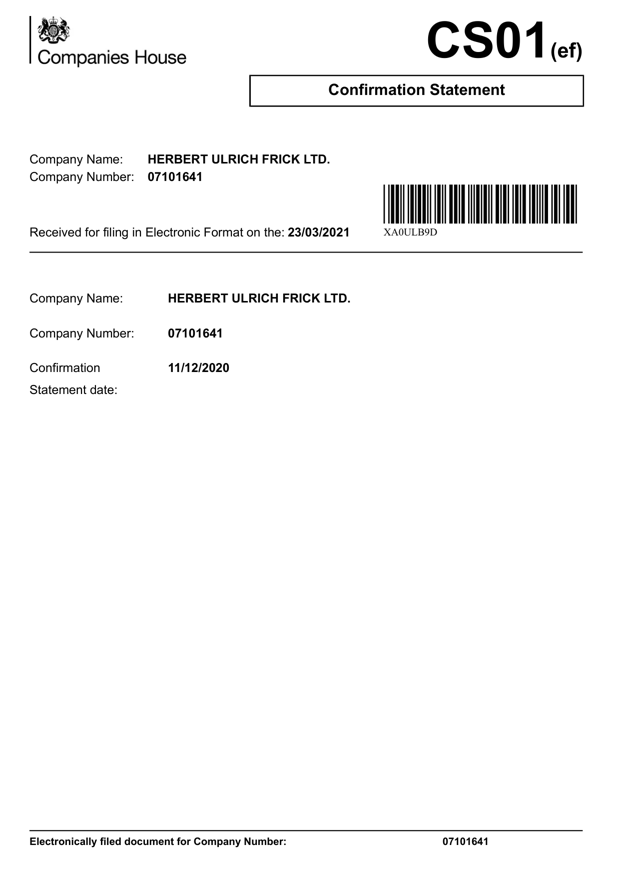
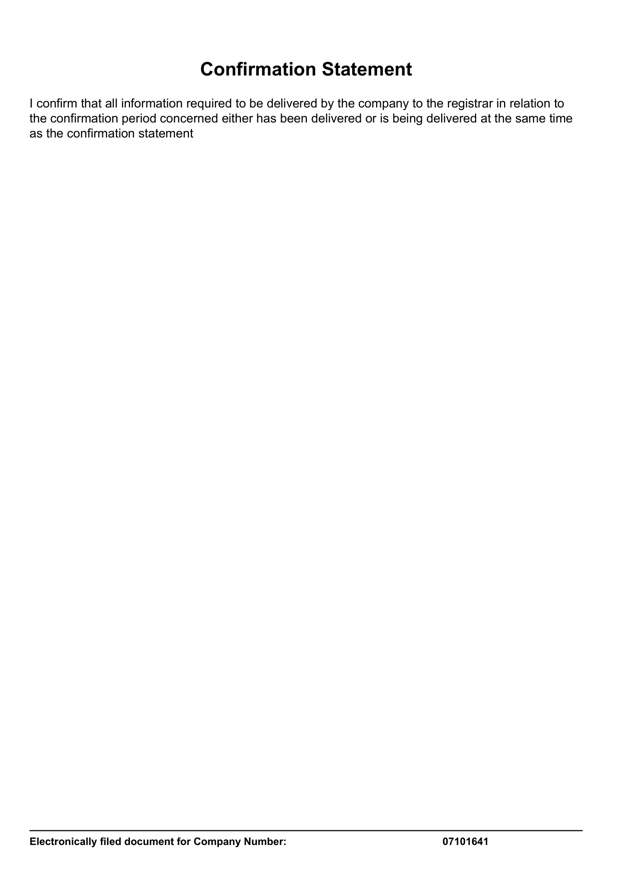
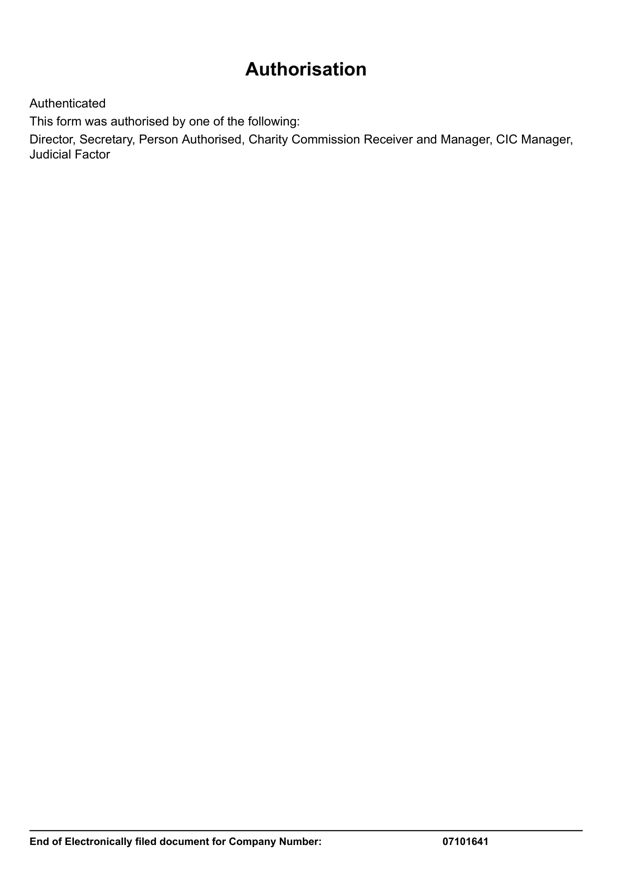

In [12]:
dataset[0]['messages']

In [13]:
dataset_filename = os.path.join(dataset_parent_path, f"{dataset_name.replace('/', '--').replace('.', '-')}.jsonl")
dataset.to_json(dataset_filename, lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

49994251

#### Upload file to S3

In [49]:
from sagemaker.s3 import S3Uploader

In [ ]:
data_s3_uri = f"s3://{sess.default_bucket()}/dataset"

uploaded_s3_uri = S3Uploader.upload(
    local_path=dataset_filename,
    desired_s3_uri=data_s3_uri
)
print(f"Uploaded {dataset_filename} to > {uploaded_s3_uri}")

## Fine-Tune LLMs using SageMaker `Estimator`/`ModelTrainer`

In [ ]:
import time
from sagemaker.pytorch import PyTorch
from sagemaker.huggingface import HuggingFace
from getpass import getpass
import yaml
from jinja2 import Template

In [ ]:
# Get Hugging Face token for model downloads (if needed)
hf_token = getpass()

### Training using `PyTorch` Estimator

**Training Using `PyTorch` Estimator**
Leverages the official PyTorch SageMaker container to run a custom training script using the Accelerate and DeepSpeed libraries. This option is ideal for users who want full control over the training pipeline 

---
**Observability**: SageMaker AI has [SageMaker MLflow](https://docs.aws.amazon.com/sagemaker/latest/dg/mlflow.html) which enables you to accelerate generative AI by making it easier to track experiments and monitor performance of models and AI applications using a single tool.

You can choose to include MLflow as a part of your training workflow to track your model fine-tuning metrics in realtime by simply specifying a **mlflow** tracking arn.

Optionally you can also report to : **tensorboard**, **wandb**.

In [ ]:
MLFLOW_TRACKING_SERVER_ARN = None # or "arn:aws:sagemaker:us-west-2:<account-id>:mlflow-tracking-server/<server-name>"

if MLFLOW_TRACKING_SERVER_ARN:
    reports_to = "mlflow"
else:
    reports_to = "tensorboard"

In [ ]:
job_name = 'meta-llama--Llama-3.2-11B-Instruct'
training_instance_type = "local_gpu"

In [ ]:
if MLFLOW_TRACKING_SERVER_ARN:
    training_env = {
        "MLFLOW_EXPERIMENT_NAME": f"exp-{job_name}",
        "MLFLOW_TAGS": '{"source.job": "sm-training-jobs", "source.type": "sft", "source.framework": "pytorch"}',
        "HF_TOKEN": hf_token,
        "MLFLOW_TRACKING_URI": MLFLOW_TRACKING_SERVER_ARN,
    }
else:
    training_env = {
        "HF_TOKEN": hf_token
    }

In [ ]:
pytorch_image_uri = f"763104351884.dkr.ecr.{region}.amazonaws.com/pytorch-training:2.8.0-gpu-py312-cu129-ubuntu22.04-sagemaker"
print(f"Using image: {pytorch_image_uri}")

#### Training strategy: `PeFT/LoRA`

In [ ]:
pytorch_estimator = PyTorch(
    image_uri=pytorch_image_uri,
    entry_point="sm_accelerate_train.sh", # Adapted bash script to train using accelerate on SageMaker - Multi-GPU
    source_dir="sagemaker_code",
    instance_type=training_instance_type,
    instance_count=1,
    base_job_name=f"{job_name}-pytorch",
    role=role,
    volume_size=300,
    py_version="py312",
    keep_alive_period_in_seconds=3600,
    environment=training_env,
    sagemaker_session=sess,
    hyperparameters={
        "config": "hf_recipes/meta-llama/Llama-3.2-11B-Vision-Instruct--vanilla-peft-qlora.yaml"
    }
)

# fit or train
pytorch_estimator.fit(
    {"training": uploaded_s3_uri}, 
    wait=False
)

In [ ]:
s3_model_data_uri = pytorch_estimator.model_data
print(f"Fine-tuned model location: {s3_model_data_uri}")

#### Training strategy: `Spectrum`

In [ ]:
pytorch_estimator = PyTorch(
    image_uri=pytorch_image_uri,
    entry_point="sm_accelerate_train.sh", # Adapted bash script to train using accelerate on SageMaker - Multi-GPU
    source_dir="sagemaker_code",
    instance_type=training_instance_type,
    instance_count=1,
    base_job_name=f"{job_name}-pytorch",
    role=role,
    volume_size=300,
    py_version="py312",
    keep_alive_period_in_seconds=3600,
    environment=training_env,
    sagemaker_session=sess,
    hyperparameters={
        "config": "hf_recipes/meta-llama/Llama-3.2-11B-Vision-Instruct--vanilla-spectrum.yaml"
    }
)

# fit or train
pytorch_estimator.fit(
    {"training": uploaded_s3_uri}, 
    wait=False
)

In [ ]:
s3_model_data_uri = pytorch_estimator.model_data
print(f"Fine-tuned model location: {s3_model_data_uri}")

#### Training strategy: `Full-Finetuning`

In [ ]:
pytorch_estimator = PyTorch(
    image_uri=pytorch_image_uri,
    entry_point="sm_accelerate_train.sh", # Adapted bash script to train using accelerate on SageMaker - Multi-GPU
    source_dir="sagemaker_code",
    instance_type=training_instance_type,
    instance_count=1,
    base_job_name=f"{job_name}-pytorch",
    role=role,
    volume_size=300,
    py_version="py312",
    keep_alive_period_in_seconds=3600,
    environment=training_env,
    sagemaker_session=sess,
     hyperparameters={
        "config": "hf_recipes/meta-llama/Llama-3.2-11B-Vision-Instruct--vanilla-full.yaml"
    }
)

# fit or train
pytorch_estimator.fit(
    {"training": uploaded_s3_uri}, 
    wait=False
)

In [ ]:
s3_model_data_uri = pytorch_estimator.model_data
print(f"Fine-tuned model location: {s3_model_data_uri}")